# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Final Exam: COVID-19 Modeling

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



### INSTRUCTIONS

- This final exam is to be completed indivudally.  Do not consult with your peers when working on it (you can aks the teaching staff for clarification questions, including private messages on Ed).
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

**Note: for all problems, it is up to you to decide how to transform the data (standardization, log transformations, etc.).  Be sure you use and interpret theses transformations approporiately.**

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

# You are free to use any functions/methods within these packages (BS4, ELI5, and LIME are fine too)
# if you would like to use any other, please contact the teaching staff 

# adding some additional imports to simplify syntax
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import power_transform

from sklearn.tree import DecisionTreeRegressor

from sklearn.utils import resample

from statsmodels.api import OLS

import warnings

In [2]:
warnings.filterwarnings("ignore")

<hr style="height:2pt">

# Analyzing the recent spread of COVID-19 

![](fig/vaccine.jpeg)

You are tasked with using the COVID case and vaccination data across counties presented by the CDC to analyze the recent surge in COVID infections and the association with (amonth other predictors).  You are also tasked with building prediction models to forecast how the disease spread will change based on data from the previous week (and  demographic and other measures.

The exam broken into 4 problems:
- Problem 1: Data Wrangling and Explorations
- Problem 2: Interpretive Linear Regression Modeling
- Problem 3: Prediction Modeling
- Problem 4: Further Analysis

You are provided with four raw data files, and a 5th cleaned file is provided to be used for all EDA and modeling tasks.

The variables included in each of the four raw data sets are:

For 'covid_cases_county.csv' (note: counties show up many times in this dataset: once for each data they report the number of cases):
- `date`: the date of the measurement, taken weekly
- `county`: county name
- `state`: the state in which the county lies
- `fips`: the unique Federal Information Processing System (FIPS) codes for the county
- `cases`: the cumulative number of confirmed positive cases up to and including that date
- `deaths`: the cumulative number of confirmed COVID-related deaths up to and including that date


For 'vaccines_county.csv' (note: counties show up many times in this dataset: once for each data they report the number of cases):
- `date`: the date of the measurement, taken weekly
- `fips`: the unique FIPS code for the county
- `fully`: the percent of residents that are fully vaccinated in the county on that date
- `dose1`: the percent of residents that have received at least one vaccine dose in the county on that date.

For 'masks_county.csv' (note: this is based on a survey conducted by the New York Times in summer of 2020):
- `fips`: the unique FIPS code for the county
- `never`: the percent of respondents that report they never wore masks in public
- `rarely`: the percent of respondents that report they rarely wore masks in public
- `sometimes`: the percent of respondents that report they sometimes wore masks in public	
- `frequently`: the percent of respondents that report they frequently wore masks in public	
- `always`: the percent of respondents that report they always wore masks in public

For 'demographics_county.csv' (note: these are various measures taken from 2010 to 2020):
- `fips`: the unique FIPS code for the county
- `population`: total number of residents in the country	
- `hispanic`: the percentage of residents that self-identify as hispanic
- `minority`: the percentage of residents that self-identify as a minority group (non-white)
- `female`: the percentage of residents that self-identify as female
- `unemployed`: the percentage of residents that are unemployed
- `income`: the median household income, in thousnads of dollards
- `nodegree`: the percentage of residents that report not having graduated high school
- `bachelor`: the percentage of residents that report having a college degree
- `inactivity`: the percentage of residents that get less than 1 hour of vigorous exercise a week
- `obesity`: the percentage of residents that are considered obese based on BMI
- `density`: the population density (residents per square mile)
- `votergap20`: Biden voting percentage minus Trump voting percentage in the 2020 election
- `votergap16`: Clinton voting percentage minus Trump voting percentage in the 2016 election


### Data Sources
- Vaccinations [here](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh).
- Cases [here](https://github.com/nytimes/covid-19-data).
- Mask Usage [here](https://github.com/nytimes/covid-19-data/tree/master/mask-use).
- Demographics [here](https://www.ers.usda.gov/data-products/county-level-data-sets/) 
- 2020 Election [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ)



## Question 1 [25pts]: Data Wrangling and Explorations </b></div>

**1.1** Load the data sets as follows:
- 'covid_cases_county.csv' as `covid_raw` 
- 'vaccines_county.csv' as `vaccines_raw`
- 'masks_county.csv' as `masks`
- 'demographics_county.csv' as `demo` 

**1.2** Create a subset of the `covid_raw` data frame that only contains the measures for 5 dates: June 27 and July 4, 11, 18 and 25.  Do the same for the `vaccines_raw`.  Call these subsets `covid` and `vaccines`, respectively, and print out their dimensions (aka, shapes).

**1.3** Determine and print the number of counties that are measured for each time period in `covid` and `vaccines` (do not print out the list of counties, just the number/count).  Comment on what this implies for presence of missing data.

**1.4** Process both `covid` and `vaccines` so that each county is represented by a single row in each data frame (rather than having 5 separate rows for each county: 1 for each time period in part 1.2).  Call these new generate Pandas data frames `covid_by_county` and `vaccines_by_county` separately.  Print out the dimensions of each resulting data frame, and view the header of `covid_by_county`.  Note: you should use informative names for the columns in the resulting data frames: for example, `cases_w30` for the cumulative number of cases on July 25 (it's the 30th week of the calendar year).

**Hint**: Splitting based on dates and then using `pd.DataFrame.merge` (source)[https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html] could be helpful for this task using the `fips` code as the keys to join on (you should drop any counties that are not measured in all time periods...the default argument for `how` in `pd.DataFrame.merge` will behave this way).

**1.5** Merge the 4 data fames (`covid_by_county`, `vaccines_by_county`, `masks`, and `demo`) based on `fips` and save the result as `covid_merged` (you should drop any counties that are not measured in all 4 data frames).  Determine and report how many counties were dropped from `demo` in this process, and view the header of `covid_merged`.

**1.6** Use `covid_merged` to calculate the novel case rate (per 1000 residents) for each of the weeks for all of the counties, and save these as 4 new well-named variables in `covid_merged`.  For example, `rate_w30` can mathematically be represented as `1000*(cases_30-cases_29)/population`.  Plot the histogram of the novel case rate in week 29, `rate_w29`, and comment on what you notice.

**1.7** We did the steps above (and some other minimal processing) and saved the results in `covid_clean.csv` for you.  Use this data file to answer some exploratory questions and all future analyses: 

1. Has the overall average case rate increased from week 28 (July 5-11) to week 29 (July 12-18)?  
2. Treating the counties as separate and equal observations: in what states did the case rate increase the most?  In what states did the case rate decrease the most (or increse the least)?  List the top 5 for each.  Do you notice any patterns in these states?
3. Create and interpret separate visuals to display how the country case rate in week 29 relates to each of the following variables. Interpret what you see (be specific to this domain).

    a. The political views in the county (as measured by the votergap in the 2020 election).
    
    b. The vaccination rate in the county (for week 28) (be sure to throw away the zeros as these represent unreported values).
    
    c. The population density of the county.
    
    d. Whether 50% or more of the surveyed residents in the county report that they always wore a mask in public at the time of the survey.

## Answers

**1.1** Load the data sets as follows:
- 'covid_cases_county.csv' as `covid_raw` 
- 'vaccines_county.csv' as `vaccines_raw`
- 'masks_county.csv' as `masks`
- 'demographics_county.csv' as `demo` 

Print out each of their dimensions (aka, shapes).

In [3]:
# Load data
covid_raw = pd.read_csv('data/covid_cases_county.csv')
vaccines_raw = pd.read_csv('data/vaccines_county.csv')
masks = pd.read_csv('data/masks_county.csv')
demo = pd.read_csv('data/demographics_county.csv')

# print shapes of the datasets
print(covid_raw.shape[1],"total columns in covid_raw, and ",covid_raw.shape[0],"rows")
print(vaccines_raw.shape[1],"total columns in vaccines_raw",vaccines_raw.shape[0],"rows")
print(masks.shape[1],"total columns in vaccines_raw",masks.shape[0],"rows")
print(demo.shape[1],"total columns in demo",demo.shape[0],"rows")

6 total columns in covid_raw, and  97394 rows
4 total columns in vaccines_raw 96720 rows
6 total columns in vaccines_raw 3142 rows
14 total columns in demo 3114 rows


**1.2** Create a subset of the `covid_raw` data frame that only contains the measures for 5 dates: June 27 and July 4, 11, 18 and 25.  Do the same for the `vaccines_raw`.  Call these subsets `covid` and `vaccines`, respectively, and print out their dimensions (aka, shapes).


In [4]:
# take a look at the covid dataset
covid_raw.head()

,date,county,state,fips,cases,deaths
0,2021-01-03,Autauga,Alabama,1001.0,4305,50.0
1,2021-01-03,Baldwin,Alabama,1003.0,14064,169.0
2,2021-01-03,Barbour,Alabama,1005.0,1530,33.0
3,2021-01-03,Bibb,Alabama,1007.0,1882,46.0
4,2021-01-03,Blount,Alabama,1009.0,4746,63.0


In [5]:
# subset the covid dataset to selected dates
covid = covid_raw.loc[
    (covid_raw['date']=='2021-06-27') |
    (covid_raw['date']=='2021-07-04') |
    (covid_raw['date']=='2021-07-11') |
    (covid_raw['date']=='2021-07-18') |
    (covid_raw['date']=='2021-07-25')
    , :]
print(covid.shape[1],"total columns in covid, and ",covid.shape[0],"rows")

6 total columns in covid, and  16227 rows


In [6]:
# take a look at the vaccine dataset
vaccines_raw.head()

,date,fips,fully,dose1
0,2021-07-25,1001,26.0,34.0
1,2021-07-25,1003,31.4,40.5
2,2021-07-25,1005,27.6,34.3
3,2021-07-25,1007,22.5,29.4
4,2021-07-25,1009,19.3,24.2


In [7]:
# subset the vaccinces dataset to selected dates
vaccines = vaccines_raw.loc[
    (vaccines_raw['date']=='2021-06-27') |
    (vaccines_raw['date']=='2021-07-04') |
    (vaccines_raw['date']=='2021-07-11') |
    (vaccines_raw['date']=='2021-07-18') |
    (vaccines_raw['date']=='2021-07-25')
    , :]
print(vaccines.shape[1],"total columns in vaccinces, and ",vaccines.shape[0],"rows")

4 total columns in vaccinces, and  16120 rows


**1.3** Determine and print the number of counties that are measured for each time period in `covid` and `vaccines` (do not print out the list of counties, just the number/count).  Comment on what this implies for presence of missing data.


In [8]:
# count the number of counties per day in the covid dataset
counties_by_day = covid.groupby('date').agg({'county': 'count',})
print("Number of counties per day in covid dataset:")
counties_by_day.head()

Number of counties per day in covid dataset:


,county
date,
2021-06-27,3245
2021-07-04,3245
2021-07-11,3245
2021-07-18,3246
2021-07-25,3246


**Comment:** Not all days have the same number of counties. It seems some days have no data for some counties (i.e. missing data).

In [9]:
# assess if there's a one-to-one relationships between counties and FIPS
fips_by_day_by_county = covid.groupby(['date','county']).agg({'fips': 'count',})
print("Number of FIPS per day by county:")
print(fips_by_day_by_county[fips_by_day_by_county['fips'] == 0].head())
print(fips_by_day_by_county[fips_by_day_by_county['fips'] > 1].head())

Number of FIPS per day by county:
                          fips
date       county             
2021-06-27 Joplin            0
           Kansas City       0
           New York City     0
           Unknown           0
2021-07-04 Joplin            0
                      fips
date       county         
2021-06-27 Adair         4
           Adams        12
           Albany        2
           Alexander     2
           Allegany      2


**Comment:** Some counties have no FIPS, and some counties have multiple FIPS.

In [10]:
# count the number of counties per day in the covid dataset
counties_by_day = covid.groupby('date').agg({'fips': 'count',})
print("Number of the unique Federal Information Processing System (FIPS) codes for the county per day in covid dataset:")
counties_by_day.head()

Number of the unique Federal Information Processing System (FIPS) codes for the county per day in covid dataset:


,fips
date,
2021-06-27,3218
2021-07-04,3218
2021-07-11,3218
2021-07-18,3218
2021-07-25,3218


In [11]:
# count the number of FIPS per day in the vaccines dataset
covid_fips_count_by_day = vaccines.groupby('date').agg({'fips': 'count',})
print("Number of FIPS per day in vaccines dataset:")
covid_fips_count_by_day.head()

Number of FIPS per day in vaccines dataset:


,fips
date,
2021-06-27,3224
2021-07-04,3224
2021-07-11,3224
2021-07-18,3224
2021-07-25,3224


**Comment:** We can observe missing data for counties and fips. Not all dates have the same number of counties in the covid dataset. The number of FIPS in the covid and vaccine datasets is also not identical. We'll need dilligence when merging the two datasets. Since some counties have no FIPS in the covid dataset, and since the vaccines dataset doesn't have county data, we will likely not be able to include the counties with missing FIPS in a vaccine analysis.

**1.4** Process both `covid` and `vaccines` so that each county is represented by a single row in each data frame (rather than having 5 separate rows for each county: 1 for each time period in part 1.2).  Call these new generate Pandas data frames `covid_by_county` and `vaccines_by_county` separately.  Print out the dimensions of each resulting data frame, and view the header of `covid_by_county`.  Note: you should use informative names for the columns in the resulting data frames: for example, `cases_w30` for the cumulative number of cases on July 25 (it's the 30th week of the calendar year).

**Hint**: Splitting based on dates and then using `pd.DataFrame.merge` (source)[https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html] could be helpful for this task using the `fips` code as the keys to join on (you should drop any counties that are not measured in all time periods...the default argument for `how` in `pd.DataFrame.merge` will behave this way).




In [12]:
# turn the long format into a wide format
# reset the index to repivot
covid_by_county = covid.reset_index(level=0)
# 
covid_by_county = covid_by_county.pivot_table(index=['fips'], columns='date',
                    values=['cases', 'deaths'], aggfunc='sum', margins=False)

In [13]:
# reformat the column names to one level
# create a list of the new column names in the right order
new_cols=[('{1} {0}'.format(*tup)) for tup in covid_by_county.columns]

# assign it to the dataframe (assuming you named it pivoted
covid_by_county.columns= new_cols

# resort the index, so you get the columns in the order you specified
covid_by_county = covid_by_county.sort_index(axis='columns')

In [14]:
# rename the columns
covid_by_county = covid_by_county.rename(columns = {'2021-06-27 cases': 'cases_w26', 
                          '2021-07-04 cases': 'cases_w27',
                          '2021-07-11 cases': 'cases_w28',
                          '2021-07-18 cases': 'cases_w29',
                          '2021-07-25 cases': 'cases_w30',
                          '2021-06-27 deaths': 'deaths_w26', 
                          '2021-07-04 deaths': 'deaths_w27',
                          '2021-07-11 deaths': 'deaths_w28',
                          '2021-07-18 deaths': 'deaths_w29',
                          '2021-07-25 deaths': 'deaths_w30',
                          }, inplace = False)

In [15]:
# check out the covid dataset
covid_by_county.head()

,cases_w26,deaths_w26,cases_w27,deaths_w27,cases_w28,deaths_w28,cases_w29,deaths_w29,cases_w30,deaths_w30
fips,,,,,,,,,,
1001.0,7244,113.0,7262,113.0,7299,113.0,7347,113.0,7419,113.0
1003.0,21945,314.0,22043,315.0,22267,318.0,22802,323.0,23810,325.0
1005.0,2344,60.0,2347,60.0,2365,60.0,2394,60.0,2434,61.0
1007.0,2686,64.0,2693,64.0,2702,65.0,2727,65.0,2801,65.0
1009.0,6967,139.0,6988,139.0,7023,139.0,7099,139.0,7184,139.0


In [16]:
# retain the number of columns for future use
nr_columns_covid_by_county = covid_by_county.shape[1]

In [17]:
# turn the long format into a wide format
# reset the index to repivot
vaccines_by_county = vaccines.reset_index(level=0)
# 
vaccines_by_county = vaccines_by_county.pivot_table(index=['fips'], columns='date',
                    values=['fully', 'dose1'], aggfunc='sum', margins=False)

In [18]:
# reformat the column names to one level
# create a list of the new column names in the right order
new_cols=[('{1} {0}'.format(*tup)) for tup in vaccines_by_county.columns]

# assign it to the dataframe (assuming you named it pivoted
vaccines_by_county.columns= new_cols

# resort the index, so you get the columns in the order you specified
vaccines_by_county = vaccines_by_county.sort_index(axis='columns')

In [19]:
# rename the columns
vaccines_by_county = vaccines_by_county.rename(columns = {
                          '2021-06-27 fully': 'fully_w26', 
                          '2021-07-04 fully': 'fully_w27',
                          '2021-07-11 fully': 'fully_w28',
                          '2021-07-18 fully': 'fully_w29',
                          '2021-07-25 fully': 'fully_w30',
                          '2021-06-27 dose1': 'dose1_w26', 
                          '2021-07-04 dose1': 'dose1_w27',
                          '2021-07-11 dose1': 'dose1_w28',
                          '2021-07-18 dose1': 'dose1_w29',
                          '2021-07-25 dose1': 'dose1_w30',
                          }, inplace = False) 

In [20]:
# merge the data with an inner join to remove counties with missing data
covid_and_vaccines_by_fips = covid_by_county.merge(vaccines_by_county, on=['fips'])

# post merge, split the data back into separate datasets
# this will allow both datasets to have an identical set of fips
covid_by_county = covid_and_vaccines_by_fips.iloc[:,:nr_columns_covid_by_county]
vaccines_by_county = covid_and_vaccines_by_fips.iloc[:,nr_columns_covid_by_county:]

In [21]:
# check out the shape of the wide datasets
print(covid_by_county.shape[1],"total columns in covid_by_county, and ",covid_by_county.shape[0],"rows")
print(vaccines_by_county.shape[1],"total columns in vaccines_by_county",vaccines_by_county.shape[0],"rows")

10 total columns in covid_by_county, and  3214 rows
10 total columns in vaccines_by_county 3214 rows


In [22]:
# inspect the covid data
covid_by_county.head()

,cases_w26,deaths_w26,cases_w27,deaths_w27,cases_w28,deaths_w28,cases_w29,deaths_w29,cases_w30,deaths_w30
fips,,,,,,,,,,
1001.0,7244,113.0,7262,113.0,7299,113.0,7347,113.0,7419,113.0
1003.0,21945,314.0,22043,315.0,22267,318.0,22802,323.0,23810,325.0
1005.0,2344,60.0,2347,60.0,2365,60.0,2394,60.0,2434,61.0
1007.0,2686,64.0,2693,64.0,2702,65.0,2727,65.0,2801,65.0
1009.0,6967,139.0,6988,139.0,7023,139.0,7099,139.0,7184,139.0


**Comment:** As expected, some records were dropped as part of the merge. There are now 3214 rows, instead of 3218. The rows are identical as an inner join merge dropped records where no matching fips were found.

**1.5** Merge the 4 data fames (`covid_by_county`, `vaccines_by_county`, `masks`, and `demo`) based on `fips` and save the result as `covid_merged` (you should drop any counties that are not measured in all 4 data frames).  Determine and report how many counties were dropped from `demo` in this process, and view the header of `covid_merged`.



In [23]:
# retain the original nr. of rows in demo
demo_fips_cnt = demo.shape[0]

# Merge the datasets
covid_merged = covid_by_county.merge(vaccines_by_county, on=['fips'])
covid_merged = covid_merged.merge(masks, on=['fips'])
covid_merged = covid_merged.merge(demo, on=['fips'])
print("The number of records dropped from demo is:", demo_fips_cnt - covid_merged.shape[0])

The number of records dropped from demo is: 6


In [24]:
covid_merged.head()

,fips,cases_w26,deaths_w26,cases_w27,deaths_w27,cases_w28,deaths_w28,cases_w29,deaths_w29,cases_w30,...,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,votergap20,votergap16
0,1001.0,7244,113.0,7262,113.0,7299,113.0,7347,113.0,7419,...,51.475,5.2,54.366,13.8,21.9,28.6,34.1,91.8,-44.418437,-49.479
1,1003.0,21945,314.0,22043,315.0,22267,318.0,22802,323.0,23810,...,51.261,5.5,49.626,11.0,28.6,22.3,27.4,114.6,-53.762343,-57.786
2,1005.0,2344,60.0,2347,60.0,2365,60.0,2394,60.0,2434,...,46.589,8.9,34.971,25.4,13.6,31.8,44.4,31.0,-7.663054,-5.611
3,1007.0,2686,64.0,2693,64.0,2702,65.0,2727,65.0,2801,...,46.110,6.6,39.546,22.1,10.2,33.9,40.3,36.8,-57.727983,-55.544
4,1009.0,6967,139.0,6988,139.0,7023,139.0,7099,139.0,7184,...,50.592,5.4,45.567,21.9,12.3,28.0,34.6,88.9,-80.002175,-81.382


**1.6** Use `covid_merged` to calculate the novel case rate (per 1000 residents) for each of the weeks for all of the counties, and save these as 4 new well-named variables in `covid_merged`.  For example, `rate_w30` can mathematically be represented as `1000*(cases_30-cases_29)/population`.  Plot the histogram of the novel case rate in week 29, July 12-18, `rate_w29`, and comment on what you notice.



In [25]:
# calculate novel case rates
covid_merged['novel_case_rate_w27'] = 1000*(covid_merged['cases_w27'] - 
                                           covid_merged['cases_w26']) / covid_merged['population']
covid_merged['novel_case_rate_w28'] = 1000*(covid_merged['cases_w28'] - 
                                           covid_merged['cases_w27']) / covid_merged['population']
covid_merged['novel_case_rate_w29'] = 1000*(covid_merged['cases_w29'] - 
                                           covid_merged['cases_w28']) / covid_merged['population']
covid_merged['novel_case_rate_w30'] = 1000*(covid_merged['cases_w30'] - 
                                           covid_merged['cases_w29']) / covid_merged['population']

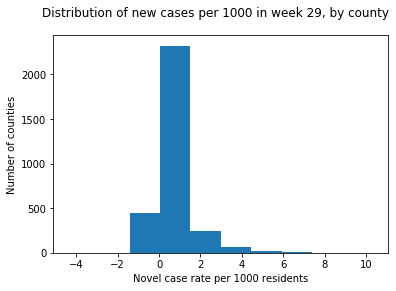

In [26]:
# show histograme for week 29
novel_case_rate_w29_hist = plt.hist(covid_merged['novel_case_rate_w29'])
plt.xlabel("Novel case rate per 1000 residents")
plt.ylabel("Number of counties")
plt.suptitle("Distribution of new cases per 1000 in week 29, by county")
plt.show()

**Comment:** Most counties showed an increase of 1 or 2 cases per thousand in week 29. A few counties had more than 2, going up to an increase of 7 cases per 1000. Close to 500 counties saw a decrease by 1 or w cases, relative to the previous week.

**1.7** We did the steps above (and some other minimal processing) and saved the results in `covid_clean.csv` for you.  Use this data file to answer some exploratory questions and all future analyses: 

1. Has the overall average case rate increased from week 28 (July 5-11) to week 29 (July 12-18)?  
2. Treating the counties as separate and equal observations: in what states did the case rate increase the most?  In what states did the case rate decrease the most (or increse the least)?  List the top 5 for each.  Do you notice any patterns in these states?
3. Create and interpret separate visuals to display how the country case rate in week 29 relates to each of the following variables. Interpret what you see (be specific to this domain).

    a. The political views in the county (as measured by the votergap in the 2020 election).
    
    b. The vaccination rate in the county (for week 28) (be sure to throw away the zeros as these represent unreported values).
    
    c. The population density of the county.
    
    d. Whether 50% or more of the surveyed residents in the county report that they always wore a mask in public at the time of the survey.

In [27]:
# read the cleaned dataset
covid_clean = pd.read_csv('data/covid_clean.csv')

**1. Has the overall average case rate increased from week 28 (July 5-11) to week 29 (July 12-18)?**

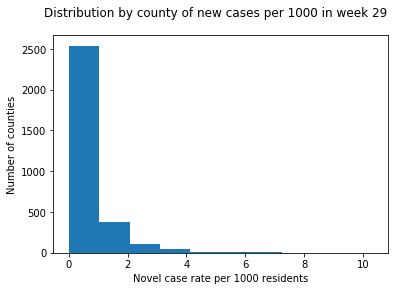

In [28]:
# plot novel cases per 1000 for w29
novel_case_rate_w29_hist = plt.hist(covid_clean['rate_w29']*1000)
plt.xlabel("Novel case rate per 1000 residents")
plt.ylabel("Number of counties")
plt.suptitle("Distribution by county of new cases per 1000 in week 29")
plt.show()

In [29]:
average_covid_increase = covid_clean['rate_w29'].mean()
print("Average covid increase per 1000 in week 29:", average_covid_increase *1000)

Average covid increase per 1000 in week 29: 0.6592153128754568


**Comment:**: The histogram shows that overall rate of covid cases has increased for all counties, on average 0.66 per thousand

**2. Treating the counties as separate and equal observations: in what states did the case rate increase the most? In what states did the case rate decrease the most (or increse the least)? List the top 5 for each. Do you notice any patterns in these states?**

In [30]:
# show the counties with the highest rate increase
covid_clean.sort_values('rate_w29', ascending=False).head()

,fips,date,county,state,cases_w30,deaths_w30,fully_w30,dose1_w30,cases_w26,deaths_w26,...,votergap16,never,rarely,sometimes,frequently,always,rate_w30,rate_w29,rate_w28,rate_w27
385,13053,2021-07-25,Chattahoochee,Georgia,4814,17,99.9,99.9,4487,17,...,-11.055,6.1,7.2,10.8,21.4,54.5,0.001319,0.010346,0.006943,0.004097
2552,48127,2021-07-25,Dimmit,Texas,2890,37,0.0,0.0,2511,37,...,37.178,2.1,5.9,9.7,13.3,69.0,0.014941,0.010131,0.006140,0.007573
149,5129,2021-07-25,Searcy,Arkansas,932,18,27.0,32.3,747,18,...,-63.144,10.0,8.8,12.5,14.9,53.8,0.008434,0.008182,0.003902,0.002769
1560,29213,2021-07-25,Taney,Missouri,7302,106,28.1,34.7,5995,99,...,-59.289,5.3,7.9,21.4,15.5,49.9,0.008663,0.008079,0.006872,0.003602
574,17015,2021-07-25,Carroll,Illinois,2043,38,47.3,54.1,1785,38,...,-27.074,3.0,6.4,12.0,19.0,59.6,0.008572,0.007620,0.000000,0.000190


In [31]:
# show the counties with the highest rate increase
covid_clean.sort_values('rate_w29', ascending=True).head(5)

,fips,date,county,state,cases_w30,deaths_w30,fully_w30,dose1_w30,cases_w26,deaths_w26,...,votergap16,never,rarely,sometimes,frequently,always,rate_w30,rate_w29,rate_w28,rate_w27
1553,29199,2021-07-25,Scotland,Missouri,307,4,20.0,22.9,306,4,...,-58.943,7.3,11.2,20.9,24.6,36.1,0.000208,0.0,0.000000,0.0
1589,30039,2021-07-25,Granite,Montana,204,2,30.2,33.3,204,2,...,-40.567,11.6,17.0,10.9,18.3,42.2,0.000000,0.0,0.000000,0.0
1597,30055,2021-07-25,McCone,Montana,183,2,14.4,14.7,183,1,...,-66.667,14.2,27.4,17.9,26.7,13.9,0.000000,0.0,0.000000,0.0
1598,30057,2021-07-25,Madison,Montana,802,8,36.4,39.2,796,8,...,-44.597,17.2,11.3,10.5,21.0,40.0,0.000536,0.0,0.000268,0.0
1599,30059,2021-07-25,Meagher,Montana,152,7,41.9,44.1,152,7,...,-55.247,18.8,9.3,12.0,20.3,39.6,0.000000,0.0,0.000000,0.0


**Comment:** At first glance it looks like the northern states had the lowest increase in cases, and the mid-country southern states had the highest increase in cases in week 29.

**Create and interpret separate visuals to display how the country case rate in week 29 relates to each of the following variables. Interpret what you see (be specific to this domain).**

**a. The political views in the county (as measured by the votergap in the 2020 election).**

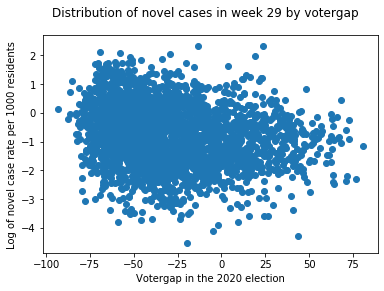

In [32]:
# plot novel cases per 1000 for w29 as a function of votergap
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(covid_clean['votergap20'],np.log(covid_clean['rate_w29']*1000))
plt.xlabel("Votergap in the 2020 election")
plt.ylabel("Log of novel case rate per 1000 residents")
plt.suptitle("Distribution of novel cases in week 29 by votergap")
plt.show()

**Comment:** Without controlling for confounding factors, there doesn't seem to be a pattern between votergap in the 2020 elections and the covid novel case rate in week 29.

**b. The vaccination rate in the county (for week 28) (be sure to throw away the zeros as these represent unreported values).**

In [33]:
covid_clean_nonzero_vac = covid_clean[covid_clean['fully_w28']!=0]
print("Nr of counties with unreported vaccination numbers in week 28:",covid_clean.shape[0]-
                                                                      covid_clean_nonzero_vac.shape[0])

Nr of counties with unreported vaccination numbers in week 28: 273


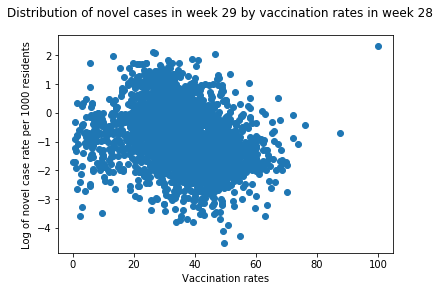

In [34]:
# plot novel cases per 1000 for w29 as a function of vaccination in the previous week
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(covid_clean_nonzero_vac['fully_w28'],np.log(covid_clean_nonzero_vac['rate_w29']*1000))
plt.xlabel("Vaccination rates")
plt.ylabel("Log of novel case rate per 1000 residents")
plt.suptitle("Distribution of novel cases in week 29 by vaccination rates in week 28")
plt.show()

**Comment:** Without controlling for confounding factors, there doesn't seem to be a pattern between vaccination rates in week 28 and the covid novel case rate in week 29.

**c. The population density of the county.**

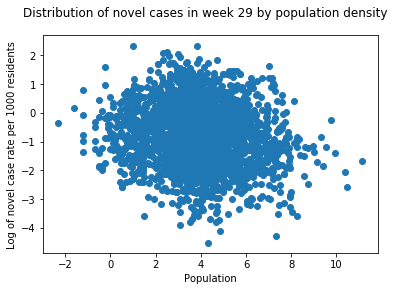

In [35]:
# plot novel cases per 1000 for w29 as a function of votergap
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(np.log(covid_clean['density']),np.log(covid_clean['rate_w29']*1000))
plt.xlabel("Population")
plt.ylabel("Log of novel case rate per 1000 residents")
plt.suptitle("Distribution of novel cases in week 29 by population density")
plt.show()

**Comment:** Without controlling for confounding factors, there doesn't seem to be a pattern between population density and the covid novel case rate in week 29.

**d. Whether 50% or more of the surveyed residents in the county report that they always wore a mask in public at the time of the survey.**

In [36]:
# subset to mask wearing higher than 50%
covid_clean_mask_adoption_above_50pc = covid_clean[covid_clean['always']>=50]
covid_clean_mask_adoption_below_50pc = covid_clean[covid_clean['always']<50]

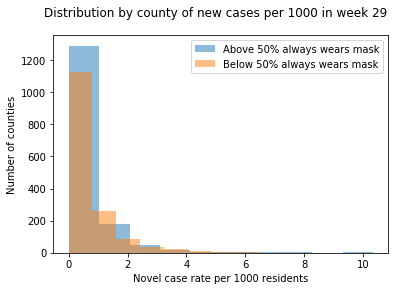

In [37]:
# plot novel cases per 1000 for w29 as a function of votergap
# show the logaritmic view to distribute the scatter more evenly
novel_case_rate_w29_hist_above_50_masked = plt.hist(covid_clean_mask_adoption_above_50pc['rate_w29']*1000, alpha=0.5, label='Above 50% always wears mask')
novel_case_rate_w29_hist_below_50_masked = plt.hist(covid_clean_mask_adoption_below_50pc['rate_w29']*1000, alpha=0.5, label='Below 50% always wears mask')
plt.xlabel("Novel case rate per 1000 residents")
plt.ylabel("Number of counties")
plt.legend()
plt.suptitle("Distribution by county of new cases per 1000 in week 29")
plt.show()

**Comment:** Without controlling for confounding factors, there seems to be rather unpronounced pattern between aobve 50 percent mask adoption and the increase in covid cases per thousand. For 100 counties, the number of cases seems 1 or 2 cases higher per thousand.

---

## Question 2 [35pts]: Regression modeling 

**2.1** Fit a linear regression model to predict `rate_w29` (which represent the rate of new cases in the week of July 12-18) from `rate_w28` (July 5-11). Report the 95% confidence intervals for the coefficients, and carefully interpret the coefficients (including their statistical significances).  What does this model suggest about whether the rate of COVID infection increased from week 28 to week 29?


**2.2** Fit a linear regression model to predict `rate_w29` from `rate_w28` and `votergap20` along with the interaction between the two.  Interpret the coefficient estimates carefully (no need to mention significances).


**2.3** Create a scatterplot of `rate_w29` vs. `rate_w28`.  Add 3 separate predicted lines from your model in 2.2 to this scatterplot: the predicted line from the model in 2.2 for counties...
    1. where Biden was favored by 50 percentage points.
    2. where Biden and Trump were equal
    3. where Trump was favored by 50 percentage points.
Interpret what you see.


**2.4** Fit a linear regression model to assess the overall association of vaccination rate (`fully_w28`) on `rate_w29`.  Carefully interpret the results (including the statistical significance).  


**2.5** Many counties have the value zero for `fully_w28` which really represents a missing/unreported value for vaccinationr rate.  Comment on the effect of ignoring this issue can have on the intepretations and inferences in the model in 2.4.  What would be a better way of handling this issue?


**2.6** What factors could be confounded (whether measured here or not) with the result seen in the model from 2.3 (list up to 3)?  Fit an appropriate linear model that controls for as many of these factors as possible (for those that are measured in this data set). Interpret the coefficient estimates from this model and compare to the results from 2.4.

**2.7** What major issue could arise if you fit a model to predict `rate_w29` from `rate_w28` and `rate_w27` (or from `fully_w28` and `fully_w27`) in a linear regression model?  Suggest and explain the use of two different approaches to account for this: one approach should be based on modeling and one approach should be based on feature engineering/variable transformations (not PCA). 

**2.8** The test set has a response variable that is `rate_w30`.  How would you use your models to predict `rate_w29` in this section in order to predict `rate_w30` instead?  Explain.  What could go wrong in this modification?

**Hint**: what should be the predictors to predict `rate_w30` instead of `rate_w29`? 


## Answers

**2.1** Fit a linear regression model to predict `rate_w29` (which represent the rate of new cases in the week of July 12-18) from `rate_w28` (July 5-11). Report the 95% confidence intervals for the coefficients, and carefully interpret the coefficients (including their statistical significances).  What does this model suggest about whether the rate of COVID infection increased from week 28 to week 29?


In [38]:
# # keep all the columns, except for non-numeric ones
# covid_clean = covid_clean.drop(['date','county', 'fips','state'],axis=1) 

# # cleaning out a couple of records with non-numeric values in votergap16
# orig_nr_rows = covid_clean.shape[0]
# covid_clean = covid_clean.loc[:,:][covid_clean['votergap16']!='#VALUE!']
# print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean.shape[0])

# #convert votergap16 to dtype float
# covid_clean['votergap16'] = covid_clean['votergap16'].astype(float)

In [39]:
# #standardize the features
# column_names = covid_clean.columns
# scale_transformer = MinMaxScaler(copy=True).fit(covid_clean)
# covid_clean = pd.DataFrame(scale_transformer.transform(covid_clean))
# covid_clean.columns = column_names

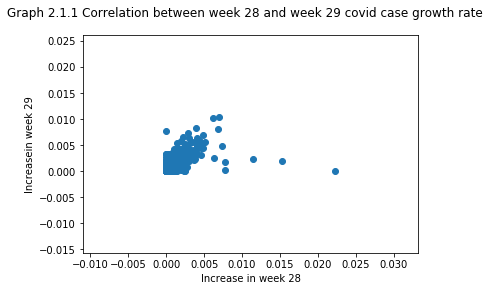

In [40]:
# plot novel cases per 1000 for w29 as a function of w29
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'])
plt.xlabel("Increase in week 28")
plt.ylabel("Increasein week 29")
plt.suptitle("Graph 2.1.1 Correlation between week 28 and week 29 covid case growth rate")
plt.show()

**Comment:** Graph 2.1.1 would indicate there is a positive linear relationship between the rate of increase in week 28 and the rate of increase in week 29. This is quite intuive as one would assume a certain level of momentum.

In [41]:
# shape the data for regression with one series
rate_w29 = covid_clean['rate_w29'].to_numpy().reshape(-1,1)
rate_w28 = covid_clean['rate_w28'].to_numpy().reshape(-1,1)

# add intercept
OLS_X = sm.tools.add_constant(rate_w28)

# fit the model on the training data
OLSModel = OLS(rate_w29,OLS_X).fit()
# print("Statmodels results: \n",OLSModel.params,sep="")
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     1938.
Date:                Tue, 03 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:06:08   Log-Likelihood:                 18129.
No. Observations:                3108   AIC:                        -3.625e+04
Df Residuals:                    3106   BIC:                        -3.624e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   1.45e-05     24.522      0.000       0.000       0.000
x1             0.6603      0.015     44.021      0.000       0.631       0.690
==============================================================================
Omnibus:                     1992.200   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           914336.075
Skew:                          -1.766   Prob(JB):                         0.00
Kurtosis:                      86.953   Cond. No.                     1.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
# grab the coefficients confidence intervals from the model
confidence_intervals = OLSModel.conf_int(alpha=0.05, cols=None)
pvalues = OLSModel.pvalues

In [43]:
# printing values from the summary table
print("The 95% confidence interval for the intercept is:", confidence_intervals[0][0], "-", confidence_intervals[0][1])
print("The statistical significance (p-value) for the intercept is:", pvalues[0])
print("The 95% confidence interval for the slope is:", confidence_intervals[1][0], "-", confidence_intervals[1][1])
print("The statistical significances (p-value) for the slope is:", pvalues[1])

The 95% confidence interval for the intercept is: 0.00032658901296613653 - 0.00038335564460932316
The statistical significance (p-value) for the intercept is: 1.5512689757340049e-121
The 95% confidence interval for the slope is: 0.6309326693377665 - 0.6897576653275962
The statistical significances (p-value) for the slope is: 0.0


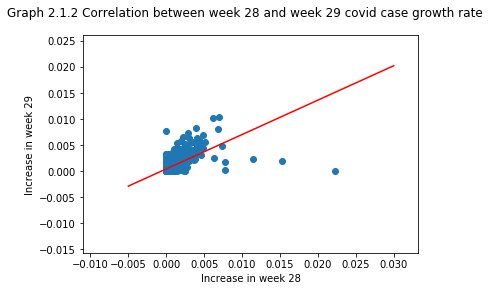

In [44]:
# plot novel cases per 1000 for w29 as a function of w29
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'])
plt.xlabel("Increase in week 28")
plt.ylabel("Increase in week 29")
i=0.0004       # intercept
s=0.6603        # slope
x=np.linspace(-0.005,0.03,20)      # from 1 to 10, by 50
plt.plot(x, s*x + i, c = 'red')    
plt.suptitle("Graph 2.1.2 Correlation between week 28 and week 29 covid case growth rate")
plt.show()

**Comment:** The statistical significance for both coefficients is 0. This means the probability that we would find these coefficients if the null hypothesis were true, is zero. As such, the coefficients are considered statistically significant.
The intercept coefficient is very close to 0. Most of the effect is therefore between rate_28 and rate_29.
The slope coefficient is estimated at 0.6603: for every increase in rate_28 for a county, we - on average - expect rate_29 rate to increase by 0.6603. As such - as the coefficient is less than one - this suggests the rate of COVID infection DEcreased from week 28 to week 29.
When graphing the relationship however, it seems reasonable to conclude that the slope is underestimated, probably due to outliers on the bottom right. Note also that the R squared is 38.4%, indicating 38.4% of the variance in rate_w29 is explained by rate_28.

**2.2** Fit a linear regression model to predict `rate_w29` from `rate_w28` and `votergap20` along with the interaction between the two.  Interpret the coefficient estimates carefully (no need to mention significances).


In [45]:
# add intercept, taking into account both regressors
covid_clean['rate_w28*votergap20'] = covid_clean['rate_w28']*covid_clean['votergap20']
OLS_x_train = sm.tools.add_constant(covid_clean[['rate_w28','votergap20', 'rate_w28*votergap20']])

# limit the target variable to pickup count for the dataset
y_train = covid_clean['rate_w29']

In [46]:
# fit the model on the training data
OLSModel = OLS(y_train,OLS_x_train).fit()
print("Statmodels results: \n",OLSModel.params,sep="")

OLSModel.summary()

Statmodels results: 
const                  0.000136
rate_w28               1.189928
votergap20            -0.000005
rate_w28*votergap20    0.010237
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rate_w29   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     873.9
Date:                Tue, 03 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:06:08   Log-Likelihood:                 18327.
No. Observations:                3108   AIC:                        -3.665e+04
Df Residuals:                    3104   BIC:                        -3.662e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0001   1.99e-05      6.819      0.000    9.68e-05       0.000
rate_w28                1.1899      0.030     39.885      0.000       1.131       1.248
votergap20          -4.804e-06   4.18e-07    -11.480      0.000   -5.62e-06   -3.98e-06
rate_w28*votergap20     0.0102      0.001     20.324      0.000       0.009       0.011
==============================================================================
Omnibus:                      982.476   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189519.319
Skew:                          -0.134   Prob(JB):                         0.00
Kurtosis:                      41.254   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

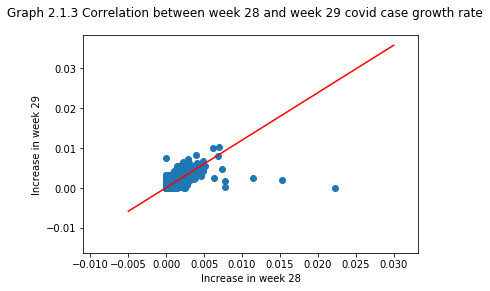

In [47]:
# plot novel cases per 1000 for w29 as a function of w29
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'])
plt.xlabel("Increase in week 28")
plt.ylabel("Increase in week 29")
i=0.0001       # intercept
s=1.1907       # slope
x=np.linspace(-0.005,0.03,20)      # from 1 to 10, by 50
plt.plot(x, s*x + i, c = 'red')    
plt.suptitle("Graph 2.1.3 Correlation between week 28 and week 29 covid case growth rate")
plt.show()

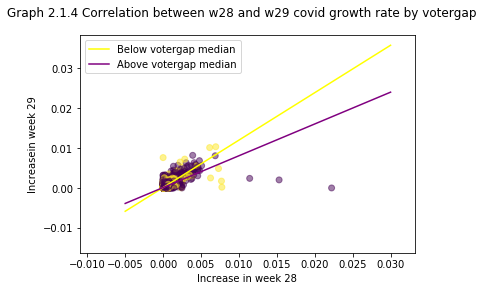

In [48]:
# plot the interaction
votergap20_median = covid_clean.votergap20.median()
covid_clean['gap20_med'] = covid_clean.votergap20 > votergap20_median
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'], c=covid_clean['gap20_med'], alpha = 0.5)
# plot below median votergap slope
x=np.linspace(-0.005,0.03,20)      # from 1 to 10, by 50
i=0.0001       # intercept
s=1.1907       # slope below median
plt.plot(x, s*x + i, c = 'yellow', label='Below votergap median')   
# plot above median votergap slope
s= 1.1907 + 0.0102 * votergap20_median
plt.plot(x, s*x + i, c = 'purple', label='Above votergap median')
plt.xlabel("Increase in week 28")
plt.ylabel("Increasein week 29")
plt.suptitle("Graph 2.1.4 Correlation between w28 and w29 covid growth rate by votergap")
plt.legend()

In [49]:
# showing all rows and columns when displaying pandas info 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [50]:
# show the outliers
print("Votergap outliers:")
covid_clean.loc[:,['county','votergap20']][covid_clean['rate_w28'] > 0.01]

Votergap outliers:


,county,votergap20
1105,Franklin,-44.362140
1607,Powder River,-71.830986
2639,Loving,-84.848485


**Comment:** 
Coefficient interpretation:
- At 0 rate_w28 and 0 votergap20, we rate_w29 mpg to be 0.0001
- For every 1 unit increase in rate_w28 (the increase in covid cases per 1000, relative to the previous week), rate_w29 increases by 1.1899 (holding votergap20 at 0)
- For every 1 unit increase in rate_w28, rate_w29 changes by 1.1899 + votergap20 * 0.0102 (where votergap20 is not 0)
- For every 1 unit increase in votergap20, rate_w29 changes by -4.804e-06 (holding rate_28 at 0)
- For every 1 unit increase in votergap20, rate_w29 changes by -4.804e-06 + rate_28 * 0.0102 (where rate_28 is not 0)

**Comment:** While the coefficient for votergap is relatively small, there is a material effect when controlling for votergap and the interaction with rate_w28. After controlling for votergap20 (and the interaction), the coefficient for rate_w28 is almost 1.19. This indicates that for every increase in rate_w28, rate_29 increased by 20% more.
After controlling for the confounding factors, the regression graph 2.1.3 also looks more reasonable.
The interaction variable indicates how different the slope for rate_w28 is as voter gap changes. As median votergap20 is negative, for each one change in voter gap, the slope for rate_w28 decreases by 0.01. This is  illustrated in graph 2.1.4 in purple. The graph also demonstrates how the purple line may be pushed down by outliers for counties Franklin, Powder River, and Loving, counties where Trump significantly outperformed Biden. R squared increases from 38.4 to 45.8 by adding votergap20.

**2.3** Create a scatterplot of `rate_w29` vs. `rate_w28`.  Add 3 separate predicted lines from your model in 2.2 to this scatterplot: the predicted line from the model in 2.2 for counties...
    1. where Biden was favored by 50 percentage points.
    2. where Biden and Trump were equal
    3. where Trump was favored by 50 percentage points.
Interpret what you see.




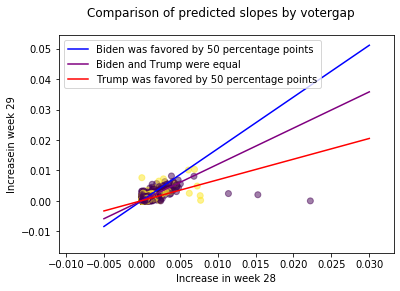

In [51]:
# plot various predicted lines for three votergap scenarios


# We can see the interaction by cutting one of the terms in the interaction along it’s median,
# and then plotting the response variable against the other variable in the interacting pair
votergap20 = covid_clean.votergap20.median()
covid_clean['gap20_med'] = covid_clean.votergap20 > votergap20_median
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'], c=covid_clean['gap20_med'], alpha = 0.5)

# line specs
x=np.linspace(-0.005,0.03,20) 
i=0.0001       # intercept

# plot where Biden was favored by 50 percentage points
votergap20 = 50
s = 1.1899 + 0.0102 * votergap20       # slope as a function of votergap20
plt.plot(x, s*x + i, c = 'blue', label='Biden was favored by 50 percentage points')   

# plot where Biden and Trump were equal
votergap20 = 0
s = 1.1899 + 0.0102 * votergap20       # slope as a function of votergap20
plt.plot(x, s*x + i, c = 'purple', label='Biden and Trump were equal')

# plot where Trump was favored by 50 percentage points.
votergap20 = -50
s = 1.1899 + 0.0102 * votergap20       # slope as a function of votergap20
plt.plot(x, s*x + i, c = 'red', label='Trump was favored by 50 percentage points')   

# Clean up plot
plt.xlabel("Increase in week 28")
plt.ylabel("Increasein week 29")
plt.suptitle("Comparison of predicted slopes by votergap")
plt.legend()

**Comment:** We can observe a lower predicted increase in counties where Trump was favored by more than 50 percentage points, and a higher predicted increase in counties where Biden was favored by more than 50 percentage points. Where Biden and Trump were equal, the week 29 increase lies in between.

**2.4** Fit a linear regression model to assess the overall association of vaccination rate (`fully_w28`) on `rate_w29`.  Carefully interpret the results (including the statistical significance).  




In [52]:
# shape the data for regression with one series
rate_w29 = covid_clean['rate_w29'].to_numpy().reshape(-1,1)
fully_w28 = covid_clean['fully_w28'].to_numpy().reshape(-1,1)

# add intercept
OLS_X = sm.tools.add_constant(fully_w28)

# fit the model on the training data
OLSModel = OLS(rate_w29,OLS_X).fit()
# print("Statmodels results: \n",OLSModel.params,sep="")
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     42.05
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           1.03e-10
Time:                        13:06:09   Log-Likelihood:                 17396.
No. Observations:                3108   AIC:                        -3.479e+04
Df Residuals:                    3106   BIC:                        -3.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009   3.65e-05     23.877      0.000       0.001       0.001
x1         -6.699e-06   1.03e-06     -6.484      0.000   -8.73e-06   -4.67e-06
==============================================================================
Omnibus:                     2459.635   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62694.782
Skew:                           3.613   Prob(JB):                         0.00
Kurtosis:                      23.783   Cond. No.                         80.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# grab the coefficients confidence intervals from the model
confidence_intervals = OLSModel.conf_int(alpha=0.05, cols=None)
pvalues = OLSModel.pvalues

# printing values from the summary table
print("The 95% confidence interval for the intercept is:", confidence_intervals[0][0], "-", confidence_intervals[0][1])
print("The statistical significance (p-value) for the intercept is:", pvalues[0])
print("The 95% confidence interval for the slope is:", confidence_intervals[1][0], "-", confidence_intervals[1][1])
print("The statistical significances (p-value) for the slope is:", pvalues[1])

The 95% confidence interval for the intercept is: 0.0008000955185946763 - 0.0009432554561701809
The statistical significance (p-value) for the intercept is: 7.936353683603603e-116
The 95% confidence interval for the slope is: -8.725069174313632e-06 - -4.673619262601985e-06
The statistical significances (p-value) for the slope is: 1.0326999433004491e-10


**Comment:** The statistical significance for both coefficients is near 0. This means the probability that we would find these coefficients if the null hypothesis were true, is zero. As such, the coefficients are considered statistically significant.
The intercept coefficient is 0.0009. When fully vaccination rate in week 28 is zero, we therefore expect the increse in covid cases in week 29 to be 0.0009.
The slope coefficient is estimated at roughly -7e-06. As such, for every increase in vaccination rate for a county, we - on average - expect rate_29 to decease by 7 in a million. Nevertheless, only 1.3% of the variance in rate_w29 is explained by fully_w28.

**2.5** Many counties have the value zero for `fully_w28` which really represents a missing/unreported value for vaccination rate.  Comment on the effect of ignoring this issue can have on the intepretations and inferences in the model in 2.4.  What would be a better way of handling this issue?




**Comment:** Since fully_w28 at zero really represents a missing / unreported value for vaccination rate, zero does not seem to be a reasonable value. First, the absence of data can reduce statistical power (the probability that the test will reject the null hypothesis when it is false). Second, the lost data can cause bias in the estimation of parameters. 
A better way of handling this, would be to impute the missing / unreported values with a reasonable value. One way to impute a reasonable value, could be to use the average vaccination rate of neighbouring counties. Alternatively, we could use a modeling technique such as regression to impute the missing value.

**2.6** What factors could be confounded (whether measured here or not) with the result seen in the model from 2.3 (list up to 3)?  Fit an appropriate linear model that controls for as many of these factors as possible (for those that are measured in this data set). Interpret the coefficient estimates from this model and compare to the results from 2.4.



**Comment:** Amongst many possible confounding factors, it seems reasonable that the results in 2.3 could be confounded by mask wearing habits, vaccination rates, and population density.

In [54]:
# prepare a model comparison dataframe
model_descriptions = ['OLS_from2.6']
idx = pd.Index(model_descriptions, name='OLS_from2.6')

# prepare a dataframe to represent rates for each model
model_comparison_df = pd.DataFrame(
    index=idx,
    columns=['training accuracy', 'test accuracy']
)


In [55]:
# prepare the data to use all possible "raw" predictors
# removing all the non-numeric columns
covid_clean_num_only = covid_clean.drop(['date','county', 'state', 'gap20_med'],axis=1) 

# removing the data for previous weeks as they are likely to be highly collinear with the values of week 28
covid_clean_num_only = covid_clean_num_only.drop(['cases_w26','deaths_w26', 'fully_w26', 'dose1_w26'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w27','deaths_w27', 'fully_w27', 'dose1_w27', 'rate_w27'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w28'],axis=1)
# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
covid_clean_num_only = covid_clean_num_only.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)



In [56]:
# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean_num_only.shape[0]
covid_clean_num_only = covid_clean_num_only.loc[:,:][covid_clean_num_only['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean_num_only.shape[0])

#convert votergap16 to dtype float
covid_clean_num_only['votergap16'] = covid_clean_num_only['votergap16'].astype(float)

Number of rows removed by cleaning up non-numeric values: 2


In [57]:
# # add interaction variables between rate_28 and the mask variables
# # drop the previous interaction variables

# covid_clean_num_only = covid_clean_num_only.drop(['rate_w28*votergap20'],axis=1) 
# # for column in ['never','rarely','sometimes','frequently', 'always', 'density', 'votergap20']:
# for column in covid_clean_num_only.columns:
#     if column != 'rate_w28' and column != 'rate_w29':
#         covid_clean_num_only[str(column) + '*' + 'rate_w28'] = covid_clean_num_only[column] * covid_clean_num_only['rate_w28']



In [58]:
#standardize the features
column_names = covid_clean_num_only.columns
scale_transformer = MinMaxScaler(copy=True).fit(covid_clean_num_only)
covid_clean_num_only = pd.DataFrame(scale_transformer.transform(covid_clean_num_only))
covid_clean_num_only.columns = column_names

In [59]:
# remove the target value from the predictor set, and add it to the target set
X = covid_clean_num_only.loc[:, covid_clean_num_only.columns != 'rate_w29']
y = covid_clean_num_only.rate_w29

In [60]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [61]:
# train a simple model
OLS_x_train = sm.tools.add_constant(X_train)
OLS_x_test = sm.tools.add_constant(X_test)

OLSModel = OLS(y_train,OLS_x_train).fit()

In [62]:
# train accuracy
y_hat_train_pred_26 = OLSModel.predict(OLS_x_train) 
train_score_26 = r2_score(y_train, y_hat_train_pred_26)

# test_accuracy
y_hat_test_pred_26 = OLSModel.predict(OLS_x_test) 
test_score_26 = r2_score(y_test.to_numpy(), y_hat_test_pred_26)

print("OLS model train accuracy: ", train_score_26)
print("OLS model train accuracy: ", test_score_26)

OLS model train accuracy:  0.49392367002904314
OLS model train accuracy:  0.45737466741384414


In [63]:
# Add best tree to comparison table
model_comparison_df.loc['OLS_from2.6','training accuracy'] = train_score_26
model_comparison_df.loc['OLS_from2.6','test accuracy'] = test_score_26
# model_comparison_df.loc['Random forest','w30 accuracy'] = score_best_RF_w30


# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
OLS_from2.6,,
OLS_from2.6,49.4%,45.7%


In [64]:
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rate_w29   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     100.0
Date:                Tue, 03 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:06:09   Log-Likelihood:                 3307.8
No. Observations:                2484   AIC:                            -6566.
Df Residuals:                    2459   BIC:                            -6420.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9538      1.710     -0.558      0.577      -4.307       2.399
fips                   -0.0366      0.005     -7.269      0.000      -0.046      -0.027
deaths_w28             -0.2622      0.191     -1.375      0.169      -0.636       0.112
fully_w28              -0.0949      0.021     -4.617      0.000      -0.135      -0.055
dose1_w28               0.0757      0.016      4.867      0.000       0.045       0.106
population              0.2923      0.159      1.842      0.066      -0.019       0.604
hispanic                0.0218      0.014      1.548      0.122      -0.006       0.049
minority                0.0132      0.013      1.036      0.300      -0.012       0.038
female                 -0.0372      0.017     -2.180      0.029      -0.071      -0.004
unemployed              0.0027      0.021      0.128      0.898      -0.039       0.044
income                 -0.0585      0.018     -3.295      0.001      -0.093      -0.024
nodegree                0.0048      0.019      0.252      0.801      -0.032       0.042
bachelor                0.1075      0.022      4.927      0.000       0.065       0.150
inactivity              0.0328      0.015      2.146      0.032       0.003       0.063
obesity                 0.0277      0.017      1.637      0.102      -0.005       0.061
density                -0.0131      0.048     -0.274      0.784      -0.107       0.081
votergap20             -0.1510      0.056     -2.676      0.007      -0.262      -0.040
votergap16              0.0356      0.053      0.670      0.503      -0.069       0.140
never                  -0.3685      0.861     -0.428      0.669      -2.057       1.320
rarely                 -0.3490      0.766     -0.456      0.649      -1.851       1.153
sometimes              -0.3753      0.839     -0.447      0.655      -2.021       1.270
frequently             -0.5095      1.037     -0.492      0.623      -2.542       1.523
always                 -0.6850      1.543     -0.444      0.657      -3.710       2.340
rate_w28                2.4125      0.073     33.166      0.000       2.270       2.555
rate_w28*votergap20     1.9413      0.107     18.064      0.000       1.731       2.152
==============================================================================
Omnibus:                      796.420   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145448.547
Skew:                           0.215   Prob(JB):                         0.00
Kurtosis:                      40.485   Cond. No.                     4.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+03

In [65]:
# # use backward selection to prune the predictors
# X = pd.DataFrame(X_train)
# # set p-value minimum to retain predictor
# cutoff = 0.05

# for i in np.arange(X.shape[1]):
#     # add the constant as statsmodel doesn't do that for us
#     OLS_x_train = sm.tools.add_constant(X)
#     # fit the model with the remaining predictors
#     OLSModel = OLS(y_train,OLS_x_train).fit()
#     # remove the predictor with the highest p-value
#     highest_non_const_p_value = np.max(OLSModel.pvalues[1:])
#     if highest_non_const_p_value > cutoff:
#         highest_non_const_p_value_name = np.argmax(OLSModel.pvalues[1:])
#         print("Predictor#:", highest_non_const_p_value_name, 
#               "with associated p-value of" ,
#               highest_non_const_p_value, 
#               "is being removed")
#         X = X.drop(highest_non_const_p_value_name,axis=1)
#         X.reset_index

# OLSModel.summary()

**Comments:** We added a significant set of possibly confounding factors. The effect of full vaccination in week28, changed: in 2.4, the coeffient for fully_w28 is -6.699e-06. After adding additional predictors, the coefficient is -0.0949. After controlling for confounding factors, full vaccination therefore predicts a materiall lower rate for week 29. 

**2.7** What major issue could arise if you fit a model to predict `rate_w29` from `rate_w28` and `rate_w27` (or from `fully_w28` and `fully_w27`) in a linear regression model?  Suggest and explain the use of two different approaches to account for this: one approach should be based on modeling and one approach should be based on feature engineering/variable transformations (not PCA). 



**Comment:** Rate_w28 and Rate_w27 will likely be highly correlated: where there's been material change in cases in one direction, we should expect a similar change the week after. Adding both feauters, therefore will increase a multicollinearity problem, making coefficients, confidence intervals and p-values unreliable. One solution (as illustrated above) is to use a predictor selection method (e.g., forward or backward selection). 
To reduce the risk of multicollinearity, it is recommended to standardize features. (@Devisch. Is this true? Should we have standardized the features for all solutions above?)

**2.8** The test set has a response variable that is `rate_w30`.  How would you use your models to predict `rate_w29` in this section in order to predict `rate_w30` instead?  Explain.  What could go wrong in this modification?

**Hint**: what should be the predictors to predict `rate_w30` instead of `rate_w29`? 


**Comment:** Our model is hard coded to predict rate_w29 from previous weeks' data. As such, if we wanted to predict rate_w30, we'd want to use e.g., rate_29 as a predictor (not rate_w28).
One solution is to keep the columns names as-is, but to shift the data by one week. We'd, for example, replace rate_w28 with rate_w29 data, rate_w27 data with rate_w28 data, rate_w26 data with rate_w27 data. We'd perform a similar operation for the other weekly metrics ('cases_w26','deaths_w26', 'fully_w26', 'dose1_w26')

Covid patterns, however, change continuously. @Devisch. It's be great to show this. As such, this approach would not hold over time. A better approach, would be to do refit the model with the more recent data.

---

## Question 3 [30pts]: Prediction modeling 

**3.1** Fit a well-tuned lasso model to predict `rate_w29` from the following set of predictors (along with all 2-way interactions among the main effects and all 2nd and 3rd order polynomial terms):

`['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 'income','nodegree','bachelor','inactivity','obesity','density','cancer','votergap20']`

Report and explain the best choice of $\lambda$ (a visual can help with this), your estimate of out-of-sample $R^2$, along with the number of coefficients that shrunk exactly to zero (or numerically zero) and the number that are non-zero.

**3.2** Plot the trajectory curves of the main effects `['rate_w28','rate_w27','fully_w28','votergap20']` from this model: the estimates of the $\beta$ coefficients as a function of $\lambda$.  Interpret what you notice.

**3.3** Fit a well-tuned random forest model to predict `rate_w29` from the predictors listed in 3.1.  Report your choice of the tuning parameters and briefly justify your choices (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.

**3.4** Interpret the relationship between `rate_w29` and `dose1_w28` from the random forest model in 3.3.  Is there any evidence of interactive effects in this model involving `dose1_w28`?  How do you know?  Provide a reasonable visual (or a few visuals) to help you with these tasks and interpret what you see. 

**3.5** Fit a well-tuned boosting model to predict `rate_w29` from the predictors listed in 3.1.  Report your best choice of the tuning parameters and briefly justify your choice (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: again, do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.

**3.6** Improve upon your favorite/best predictive model from 3.1, 3.3, or 3.5, by including other provided feature, by doing feature engineering, or by doing variable removal/selection.  Explain your choices.  Provide an estimate of out-of-sample $R^2$. 

**3.7** Evaluate your models from 3.1, 3.3, 3.5, and 3.6 on the test set (this will take some work...refer back to 2.8) using $R^2$.  How do these model's $R^2$ in test compare to the out-of-sample $R^2$ when tuning?  Explain whether this is surprising or not?



## Answers

**3.1** Fit a well-tuned lasso model to predict `rate_w29` from the following set of predictors (along with all 2-way interactions among the main effects and all 2nd and 3rd order polynomial terms):

`['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 'income','nodegree','bachelor','inactivity','obesity','density','cancer','votergap20']`

Report and explain the best choice of $\lambda$ (a visual can help with this), your estimate of out-of-sample $R^2$, along with the number of coefficients that shrunk exactly to zero (or numerically zero) and the number that are non-zero.


In [66]:
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')

In [67]:
# downselect columns
# not including 'cancer'
columns = ['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 
            'income','nodegree','bachelor','inactivity','obesity','density','votergap20']
X = covid_clean.loc[:,columns]
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
X = X.reindex()
y = y.reindex()

# add a week 30 version with an identical split for easy model testing on never seen target data
y_w30_test_lasso, y_w30_test_lasso = train_test_split(pd.DataFrame(covid_clean.loc[:,['rate_w30']]), test_size=0.2, random_state = 109)


In [68]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [69]:
# Note how the number of rows for X_train and X_test is different, but number of columns is identical
print("X_train shape", X_train.shape)
print("X_train shape", X_test.shape)

X_train shape (2486, 14)
X_train shape (622, 14)


In [70]:
def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    # walk through the columns for which to add polynomials
    for column in columns:
        # create 2+ degree polynomials
        for polynomial in range(degree):
            # ignore polynomials with exponent 0 and 1
            polynomial = polynomial + 2
            if polynomial <= degree:
                # create the new columns
                dataset[str(column) + "_" + str(polynomial)] = dataset[column] ** polynomial
    poly_dataset = dataset
    return poly_dataset

In [71]:
# add second and third polynomials
X_train = add_poly_features(X_train, 3, columns)
X_test = add_poly_features(X_test, 3, columns)
# take a quick look at the dataset
print(X_train.shape)
print(X_test.shape)
X_train.describe()

(2486, 42)
(622, 42)


,rate_w28,rate_w27,dose1_w28,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,votergap20,rate_w28_2,rate_w28_3,rate_w27_2,rate_w27_3,dose1_w28_2,dose1_w28_3,hispanic_2,hispanic_3,minority_2,minority_3,female_2,female_3,unemployed_2,unemployed_3,income_2,income_3,nodegree_2,nodegree_3,bachelor_2,bachelor_3,inactivity_2,inactivity_3,obesity_2,obesity_3,density_2,density_3,votergap20_2,votergap20_3
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2.486000e+03,2.486000e+03,2.486000e+03,2.486000e+03,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2.486000e+03,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2.486000e+03,2.486000e+03,2486.000000,2486.000000
mean,0.000464,0.000342,33.287450,9.090958,15.154235,49.933473,5.496862,47.022739,15.083186,20.084071,26.004666,31.086806,249.274980,-31.350442,9.611894e-07,7.991431e-09,4.422927e-07,1.276795e-09,1475.112325,70795.119427,259.870570,12949.554667,488.683775,22799.432410,2498.461944,125230.913555,33.985133,237.530451,2357.664576,1.272900e+05,273.708858,5801.503404,482.144200,13933.529220,703.343765,19689.430506,987.080048,31941.701838,3.145418e+06,1.606622e+11,2008.708145,-101185.740439
std,0.000864,0.000571,19.162613,13.315268,16.097738,2.261024,1.941946,12.107252,6.798894,8.877274,5.206919,4.549600,1756.280426,32.035461,1.138557e-05,2.322867e-07,2.309141e-06,1.300219e-08,1210.562758,81206.446022,862.774827,64612.250615,1017.626641,68925.260770,210.286279,14873.375242,27.533002,406.643070,1388.679660,1.361386e+05,255.368702,8938.697829,497.208078,25934.762391,271.435453,11197.128206,278.434369,13310.060194,1.006039e+08,6.784742e+12,1738.444242,142307.256460
min,0.000000,0.000000,0.000000,0.205000,0.855000,29.748000,1.800000,21.658000,1.300000,2.600000,8.700000,11.800000,0.200000,-91.586539,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.042025,0.008615,0.731025,0.625026,884.943504,26325.299357,3.240000,5.832000,469.068964,1.015910e+04,1.690000,2.197000,6.760000,17.576000,75.690000,658.503000,139.240000,1643.032000,4.000000e-02,8.000000e-03,0.000543,-768236.497224
25%,0.000087,0.000052,24.950000,2.146250,4.274500,49.469750,4.100000,38.887000,9.900000,14.000000,22.700000,28.400000,17.500000,-56.338861,7.551632e-09,6.562386e-13,2.727875e-09,1.424749e-13,622.510000,15531.999500,4.606389,9.886464,18.271351,78.100896,2447.256167,121065.150922,16.810000,68.921000,1512.198769,5.880487e+04,98.010000,970.299000,196.000000,2744.000000,515.290000,11697.083000,806.560000,22906.304000,3.062500e+02,5.359375e+03,468.298507,-178823.331736
50%,0.000244,0.000174,36.400000,4.019500,8.237500,50.372000,5.300000,45.163500,13.700000,18.000000,25.900000,31.300000,45.600000,-37.710481,5.959031e-08,1.454669e-11,3.032767e-08,5.281528e-12,1324.960000,48228.544000,16.156380,64.940573,67.856412,558.967301,2537.338384,127810.809079,28.090000,148.877000,2039.741753,9.212188e+04,187.690000,2571.353000,324.000000,5832.000000,670.810000,17373.979000,979.690000,30664.297000,2.079360e+03,9.481882e+04,1616.058528,-53627.361850
75%,0.000553,0.000401,46.275000,9.343750,20.187750,51.074000,6.500000,52.442000,19.400000,23.900000,29.500000,33.900000,116.775000,-13.373992,3.054592e-07,1.688241e-10,1.606849e-07,6.441150e-11,2141.377500,99092.417250,87.305664,815.762304,407.547478,8227.556417,2608.553476,133229.260233,42.250000,274.625000,2750.163376,1.442241e+05,376.360000,7301.384000,571.210000,13651.919000,870.250000,25672.375000,1149.210000,38958.219000,1.363640e+04,1.592391e+06,3239.048148,-2392.121326
max,0.022222,0.007184,99.900000,95.824000,89.035000,56.739000,24.000000,125.635000,53.300000,75.100000,41.400000,47.600000,69468.400000,76.596157,4.938272e-04,1.097394e-05,5.160990e-05,3.707657e-07,9980.010000,99

In [72]:
def build_interaction(df, columns):
    # create a copy of the columns and dataframes to avoid unintentionally changing the original set
    interact_left = columns.copy()
    interact_right = columns.copy()
    result_df = df.copy()

    # create interaction features for all the requested columns
    for left in interact_left:
        # avoid multiplying by oneself, or producing the same column twice
        interact_right.remove(left)
        for right in interact_right:
            # create an interaction column by multiplying the numbers
            if left != right:
                result_df[str(left) + '_*_' + str(right)] = df[left] * df[right]
    return result_df

In [73]:
# add interaction variables
X_train = build_interaction(X_train, columns)
X_test = build_interaction(X_test, columns)
print(X_train.shape)
print(X_test.shape)
# X_train.describe()

(2486, 133)
(622, 133)


In [74]:
#standardize the features
column_names = X_train.columns
scale_transformer = MinMaxScaler(copy=True).fit(X_train)
X_train = pd.DataFrame(scale_transformer.transform(X_train))
X_test = pd.DataFrame(scale_transformer.transform(X_test))
X_train.columns = column_names
X_test.columns = column_names


scale_transformer = MinMaxScaler(copy=True).fit(y_train)
y_train = pd.DataFrame(scale_transformer.transform(y_train))
y_test = pd.DataFrame(scale_transformer.transform(y_test))

In [75]:
# take a quick look at the standardized dataset
# Note that, as expected, all features are scaled between 0 and 1
print(X_train.shape)
print(X_test.shape)
X_train.describe()

(2486, 133)
(622, 133)


,rate_w28,rate_w27,dose1_w28,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,votergap20,rate_w28_2,rate_w28_3,rate_w27_2,rate_w27_3,dose1_w28_2,dose1_w28_3,hispanic_2,hispanic_3,minority_2,minority_3,female_2,female_3,unemployed_2,unemployed_3,income_2,income_3,nodegree_2,nodegree_3,bachelor_2,bachelor_3,inactivity_2,inactivity_3,obesity_2,obesity_3,density_2,density_3,votergap20_2,votergap20_3,rate_w28_*_rate_w27,rate_w28_*_dose1_w28,rate_w28_*_hispanic,rate_w28_*_minority,rate_w28_*_female,rate_w28_*_unemployed,rate_w28_*_income,rate_w28_*_nodegree,rate_w28_*_bachelor,rate_w28_*_inactivity,rate_w28_*_obesity,rate_w28_*_density,rate_w28_*_votergap20,rate_w27_*_dose1_w28,rate_w27_*_hispanic,rate_w27_*_minority,rate_w27_*_female,rate_w27_*_unemployed,rate_w27_*_income,rate_w27_*_nodegree,rate_w27_*_bachelor,rate_w27_*_inactivity,rate_w27_*_obesity,rate_w27_*_density,rate_w27_*_votergap20,dose1_w28_*_hispanic,dose1_w28_*_minority,dose1_w28_*_female,dose1_w28_*_unemployed,dose1_w28_*_income,dose1_w28_*_nodegree,dose1_w28_*_bachelor,dose1_w28_*_inactivity,dose1_w28_*_obesity,dose1_w28_*_density,dose1_w28_*_votergap20,hispanic_*_minority,hispanic_*_female,hispanic_*_unemployed,hispanic_*_income,hispanic_*_nodegree,hispanic_*_bachelor,hispanic_*_inactivity,hispanic_*_obesity,hispanic_*_density,hispanic_*_votergap20,minority_*_female,minority_*_unemployed,minority_*_income,minority_*_nodegree,minority_*_bachelor,minority_*_inactivity,minority_*_obesity,minority_*_density,minority_*_votergap20,female_*_unemployed,female_*_income,female_*_nodegree,female_*_bachelor,female_*_inactivity,female_*_obesity,female_*_density,female_*_votergap20,unemployed_*_income,unemployed_*_nodegree,unemployed_*_bachelor,unemployed_*_inactivity,unemployed_*_obesity,unemployed_*_density,unemployed_*_votergap20,income_*_nodegree,income_*_bachelor,income_*_inactivity,income_*_obesity,income_*_density,income_*_votergap20,nodegree_*_bachelor,nodegree_*_inactivity,nodegree_*_obesity,nodegree_*_density,nodegree_*_votergap20,bachelor_*_inactivity,bachelor_*_obesity,bachelor_*_density,bachelor_*_votergap20,inactivity_*_obesity,inactivity_*_density,inactivity_*_votergap20,obesity_*_density,obesity_*_votergap20,density_*_votergap20
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2.486000e+03,2486.000000,2.486000e+03,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2.486000e+03,2.486000e+03,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,0.020866,0.047571,0.333208,0.092931,0.162160,0.747859,0.166525,0.243946,0.265061,0.241160,0.529195,0.538738,0.003585,0

In [76]:
# put y_train in the expected format
y_train = y_train.values.ravel()

In [77]:
# get the locations for columns of interest (for later use)
rate_w28_loc = X_train.columns.get_loc('rate_w28')
rate_w27_loc = X_train.columns.get_loc('rate_w27')
dose1_w28_loc = X_train.columns.get_loc('dose1_w28')
votergap20_loc = X_train.columns.get_loc('votergap20')

rate_w28_coefs = []
rate_w27_coefs = []
dose1_w28_coefs = []
votergap20_coefs = []

In [78]:
# choose from a range of lambdas (lasso penalties)
lambdas = [0.0001, 0.001, 0.01, 0.1]

# initialize variables
best_accuracy = -1
best_model = None
accuracies = []
models = []

# experiment with different lambdas
for c in lambdas:
    #@Devisch should we use cross validation instead?
    covid_lasso = Lasso(alpha=c, max_iter=100000, fit_intercept=True)
    covid_lasso.fit(X_train, y_train)
    y_hat_test = covid_lasso.predict(X_test)
    cur_accuracy = r2_score(y_test.to_numpy(), y_hat_test)

    # adding accuracy to a list in case we want to show how accuracy changes with lambda
    accuracies.append(cur_accuracy)
    models.append(covid_lasso)

    # track how specific coefficients change as a function of lambda
    rate_w28_coefs.append(covid_lasso.coef_[rate_w28_loc])
    rate_w27_coefs.append(covid_lasso.coef_[rate_w27_loc])
    dose1_w28_coefs.append(covid_lasso.coef_[dose1_w28_loc])
    votergap20_coefs.append(covid_lasso.coef_[votergap20_loc])
    
    # retain the best model
    if cur_accuracy > best_accuracy:
        best_accuracy = cur_accuracy
        best_lasso_model = covid_lasso
        best_lambda = c
            
        # train accuracy
        y_train_pred = covid_lasso.predict(X_train) 
        best_train_score = r2_score(y_train, y_train_pred)
        
        

print("Best lambda is:",best_lambda )
print("Best test accuracy is:",best_accuracy )

Best lambda is: 0.001
Best test accuracy is: 0.5237934045455788


Text(0.5, 1.0, 'Test R squared')

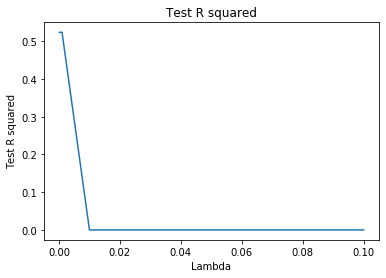

In [79]:
plt.plot(lambdas,accuracies)
plt.xlabel("Lambda")
plt.ylabel("Test R squared")
plt.title("Test R squared")

In [80]:
# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [26,27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
#         print(next_feature, "in", curr_feature)
        covid_clean_w30[curr_feature] = covid_clean_w30[next_feature]

X_w30 = covid_clean_w30.loc[:,columns]
y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()


In [81]:
print(curr_feature)
print(covid_clean_w30[curr_feature].head())
print(next_feature)
print(covid_clean_w30[next_feature].head())

rate_w28
0    0.000946
1    0.002974
2    0.000975
3    0.001158
4    0.001303
Name: rate_w28, dtype: float64
rate_w29
0    0.000946
1    0.002974
2    0.000975
3    0.001158
4    0.001303
Name: rate_w29, dtype: float64


In [82]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

In [83]:

# add second and third polynomials
X_train_w30 = add_poly_features(X_train_w30, 3, columns)
X_test_w30 = add_poly_features(X_test_w30, 3, columns)

# add interaction variables
X_train_w30 = build_interaction(X_train_w30, columns)
X_test_w30 = build_interaction(X_test_w30, columns)
print(X_train_w30.shape)
print(X_test_w30.shape)
# X_train.describe()

#standardize the predictors
column_names = X_train_w30.columns
# scale_transformer = MinMaxScaler(copy=True).fit(X_train_w30)
X_train_w30 = pd.DataFrame(scale_transformer.transform(X_train))
X_test_w30 = pd.DataFrame(scale_transformer.transform(X_test))
X_train_w30.columns = column_names
X_test_w30.columns = column_names

#standardize the target
scale_transformer = MinMaxScaler(copy=True).fit(y_train_w30)
y_train_w30 = pd.DataFrame(scale_transformer.transform(y_train_w30))
y_test_w30 = pd.DataFrame(scale_transformer.transform(y_test_w30))

# w30 accuracy
y_hat_test_w30 = covid_lasso.predict(X_test_w30) 
score_best_lasso_w30 = r2_score(y_test_w30, y_hat_test_w30)

(2486, 133)
(622, 133)


**Comment:** Note how only small values of lambda produce a reasonable R squared score. Once the score reaches 1%, test score plummet. The penality is too high, and all coefficients become zero.

In [84]:
# prepare a dataframe with the coefficients
coef_pd = pd.DataFrame(np.transpose([best_lasso_model.coef_]),
            columns = ["best_lasso_model_coeff"], index=X_train.columns)

In [85]:
print("The number of NON-zero coefficients:", coef_pd[:][coef_pd['best_lasso_model_coeff']!=0].shape[0])
print("The number of zero coefficients:", coef_pd[:][coef_pd['best_lasso_model_coeff']==0].shape[0])

The number of NON-zero coefficients: 5
The number of zero coefficients: 128


**Comment:** Note how only five coefficients are non-zero.

In [86]:
# print all the non-zero coefficients
coef_pd[:][coef_pd['best_lasso_model_coeff']!=0]

,best_lasso_model_coeff
inactivity,0.004939
rate_w28_*_bachelor,0.441355
rate_w27_*_unemployed,0.022043
rate_w27_*_inactivity,0.342558
nodegree_*_inactivity,0.010141


In [87]:
# Add best tree to comparison table
model_comparison_df.loc['Poly, interact and lasso','test accuracy'] = best_accuracy
model_comparison_df.loc['Poly, interact and lasso','training accuracy'] = best_train_score
model_comparison_df.loc['Poly, interact and lasso','w30 accuracy'] = score_best_lasso_w30
# model_comparison_df.loc['Poly, interact and lasso','w30 accuracy'] = w30_accuracy

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,    
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,,,
OLS_from2.6,49.4%,45.7%,nan%
"Poly, interact and lasso",49.6%,52.4%,-11.4%


In [88]:
# from sklearn.linear_model import Lasso
# lasso_alpha0001 = Lasso(alpha=0.0001,fit_intercept=True,max_iter=100000).fit(X_train , y_train)
# lasso_alpha001 = Lasso(alpha=0.001,fit_intercept=True,max_iter=100000).fit(X_train , y_train)
# lasso_alpha01 = Lasso(alpha=0.01,fit_intercept=True,max_iter=100000).fit(X_train , y_train)
# lasso_alpha1 = Lasso(alpha=1,fit_intercept=True`a,max_iter=1000).fit(X_train , y_train)
# lasso_alpha10 = Lasso(alpha=10,fit_intercept=True,max_iter=1000).fit(X_train , y_train)
# lasso_alpha100 = Lasso(alpha=100,fit_intercept=True,max_iter=1000).fit(X_train , y_train)

# # Add everything to a table
# coef_pd = pd.DataFrame(np.transpose([lasso_alpha0001.coef_,lasso_alpha001.coef_,lasso_alpha01.coef_,
#                           lasso_alpha1.coef_,lasso_alpha10.coef_,lasso_alpha100.coef_]),
#             columns = ["lasso_alpha0001","lasso_alpha001","lasso_alpha01","lasso_alpha1",
#                        "lasso_alpha10","lasso_alpha100",], index=X_train.columns)




**3.2** Plot the trajectory curves of the main effects `['rate_w28','rate_w27','fully_w28','votergap20']` from this model: the estimates of the $\beta$ coefficients as a function of $\lambda$.  Interpret what you notice.


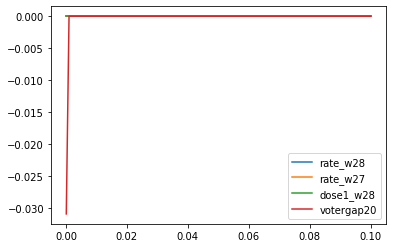

In [89]:
plt.plot(lambdas, rate_w28_coefs, label="rate_w28")
plt.plot(lambdas, rate_w27_coefs, label="rate_w27")
plt.plot(lambdas, dose1_w28_coefs, label="dose1_w28")
plt.plot(lambdas, votergap20_coefs, label="votergap20")
plt.legend()

**Comment:** The coefficients for all predictors except votergap have been shrunk to zero fo all values of lambda. Only the smallest lambda retains a predictor: votergap20.

**3.3** Fit a well-tuned random forest model to predict `rate_w29` from the predictors listed in 3.1.  Report your choice of the best tuning parameters and briefly justify your choice (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.


In [90]:
# start random forest
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')
# downselecting columns
# not including 'cancer'
columns = ['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 
            'income','nodegree','bachelor','inactivity','obesity','density','votergap20']
X = covid_clean.loc[:,columns]
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
# X_train = X_train.reindex()
# y_train = y_train.reindex()

# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [91]:
# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [26,27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
#         print(next_feature, "in", curr_feature)
        covid_clean_w30[curr_feature] = covid_clean_w30[next_feature]

X_w30 = covid_clean_w30.loc[:,columns]
y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()


In [92]:
# prepare a dataframe to represent rates for each model
random_forest_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [93]:
random_forest_train_score = -1
random_forest_test_score = -1
depth_option = 7
tree_nr_options = [10,20,50,100]
depth_options = [5, 10, 15]
max_features_list = [2,5,10,len(X_train.columns)]
row_number = 0

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for max_features in max_features_list:
            estimators = []
            R2s_train = []
            R2s_test = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            randomtree = RandomForestRegressor(max_depth=depth_option, max_features = max_features)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,randomtree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,randomtree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,randomtree.score(X_test, y_test))
            
            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option) + " and max_features " + str(max_features)
            random_forest_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            random_forest_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            row_number = row_number + 1
            # retain the best scores
            if np.mean(R2s_test) > random_forest_test_score:
                random_forest_test_score = np.mean(R2s_test)
                random_forest_train_score = np.mean(R2s_train)
                best_tree_nr = ntrees
                best_depth = depth_option
                best_max_features = max_features
                best_RF_model = randomtree
                

In [94]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)


In [95]:
# w30 accuracy
y_hat_test_w30 = best_RF_model.predict(X_test_w30) 
score_best_RF_w30 = r2_score(y_test_w30, y_hat_test_w30)

In [96]:
# Print out the best test scores
random_forest_comparison_df.sort_values('test accuracy', ascending=False).head()

,training accuracy,test accuracy
50 bagged trees w/ depth 15 and max_features 10,0.747795,0.669676
100 bagged trees w/ depth 5 and max_features 10,0.70849,0.653728
50 bagged trees w/ depth 15 and max_features 14,0.79552,0.624135
20 bagged trees w/ depth 5 and max_features 10,0.714866,0.6225
100 bagged trees w/ depth 10 and max_features 10,0.792684,0.622242


**Comment:** We're choosing the model with the best test accuracy:

In [97]:
print("The best tree number is:", best_tree_nr)
print("The best tree depth is:", best_depth)
print("The best max_features is:", best_max_features)

The best tree number is: 50
The best tree depth is: 15
The best max_features is: 10


In [98]:
# Add best tree to comparison table
model_comparison_df.loc['Random forest','training accuracy'] = random_forest_train_score
model_comparison_df.loc['Random forest','test accuracy'] = random_forest_test_score
model_comparison_df.loc['Random forest','w30 accuracy'] = score_best_RF_w30


# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,,,
OLS_from2.6,49.4%,45.7%,nan%
"Poly, interact and lasso",49.6%,52.4%,-11.4%
Random forest,74.8%,67.0%,58.1%


**3.4** Interpret the relationship between `rate_w29` and `dose1_w28` from the random forest model in 3.3.  Is there any evidence of interactive effects in this model involving `dose1_w28`?  How do you know?  Provide a reasonable visual (or a few visuals) to help you with these tasks and interpret what you see. 



In [99]:
# Create the data frame of means to do the prediction
means1 = X_train.mean(axis = 0)
means_df = (means1.to_frame()).transpose()

# Do the prediction at all observed dose1_w28
doses = np.arange(np.min(X_train['dose1_w28']),np.max(X_train['dose1_w28']))
means_df  = pd.concat([means_df]*doses.size,ignore_index=True)
means_df['dose1_w28'] = doses


In [100]:
means1.to_frame().transpose()

,rate_w28,rate_w27,dose1_w28,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,votergap20
0,0.000464,0.000342,33.28745,9.090958,15.154235,49.933473,5.496862,47.022739,15.083186,20.084071,26.004666,31.086806,249.27498,-31.350442


Text(0, 0.5, 'Rate_w29')

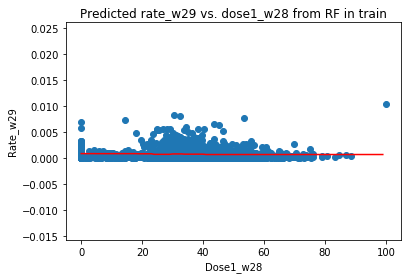

In [101]:
#plots at means
yhat_rf = best_RF_model.predict(means_df)
plt.scatter(X_train['dose1_w28'],y_train)
plt.plot(means_df['dose1_w28'],yhat_rf,color="red")
plt.title("Predicted rate_w29 vs. dose1_w28 from RF in train")
plt.xlabel("Dose1_w28")
plt.ylabel("Rate_w29")

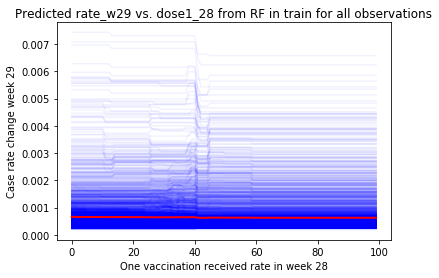

In [102]:
#Plots for all observations.  And then averaged
yhat_rfs = []
for i in range(0,X_train.shape[0]):
    obs = X_train.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*doses.size,ignore_index=True)
    obs_df['dose1_w28'] = doses
    yhat_rf = best_RF_model.predict(obs_df)
    yhat_rfs.append(yhat_rf)
    plt.plot(obs_df['dose1_w28'],yhat_rf,color='blue',alpha=0.05)

plt.plot(obs_df['dose1_w28'],np.mean(yhat_rfs, axis=0),color='red',linewidth=2);
    
# plt.ylim(0,1)
plt.xlabel("One vaccination received rate in week 28")
plt.ylabel("Case rate change week 29")
plt.title("Predicted rate_w29 vs. dose1_28 from RF in train for all observations");


**Comment:** We can observe that in the randomforest model dose1_w28 does not have much of an effect on predicted values: the red (average) line is flat. We also plotted the full range of dose1_w28 for each observation in the training set. We can observe that the graph shape for dose1_w28 varies only marginally between the observations. We can therefore conclude that limited interaction effects exist between dose1_w28 and other predictors.

**3.5** Fit a well-tuned boosting model to predict `rate_w29` from the predictors listed in 3.1.  Report your best choice of the tuning parameters and briefly justify your choice (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: again, do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.



In [103]:
boosts = []
boostfts = []
depths = [1, 2, 3, 4,5,6,7]
# build boost models with base estimators of different depths
for base_depth in depths:
    boost = AdaBoostRegressor( base_estimator = DecisionTreeRegressor(max_depth = base_depth),
                              n_estimators=100)
    boosts.append(boost)


    # Fit on the entire data
    boostfit = boost.fit(X_train,y_train)
    boostfts.append(boostfit)

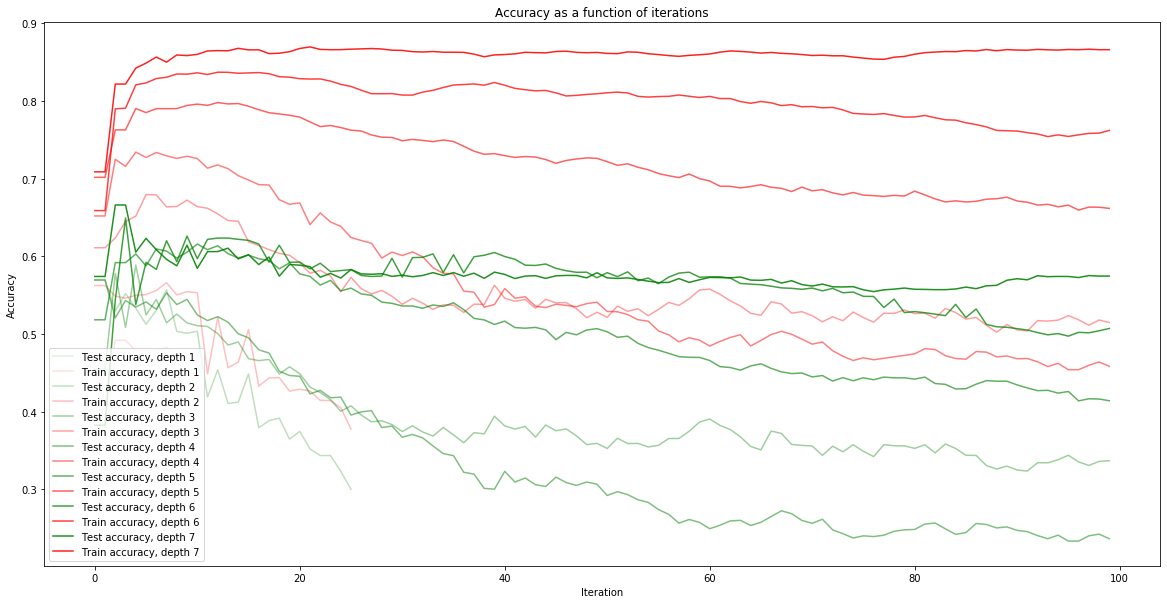

In [104]:
# plot accuracy by estimator for different base depths
plt.rcParams["figure.figsize"] = (20,10)
for base_depth in depths:
    plt.plot(list(boosts[base_depth -1].staged_score(X_test,y_test)),
             label="Test accuracy, depth " + str(base_depth), color = "green", alpha = base_depth/8)
    plt.plot(list(boosts[base_depth -1].staged_score(X_train,y_train)),
             label="Train accuracy, depth " + str(base_depth), color = "red", alpha = base_depth/8)
    plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of iterations")
plt.legend()

In [105]:
# list(boosts[3].staged_score(X_train,y_train))

In [106]:
# we've visually assessed initial depth equal to three to be the best option
best_depth = 3
best_boost = boosts[best_depth -1]
train_list = list(best_boost.staged_score(X_train,y_train))
test_list = list(best_boost.staged_score(X_test,y_test))

# assess which iteration is best
index_best_accuracy = test_list.index(max(test_list))
print("The iteration with the best accuracy is:", index_best_accuracy)

The iteration with the best accuracy is: 4


In [107]:
# w30 accuracy
w30_list = list(best_boost.staged_score(X_test_w30,y_test_w30))

In [108]:
# Add best tree to comparison table
model_comparison_df.loc['Adaboost','training accuracy'] = train_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','test accuracy'] = test_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','w30 accuracy'] = w30_list[index_best_accuracy]

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,,,
OLS_from2.6,49.4%,45.7%,nan%
"Poly, interact and lasso",49.6%,52.4%,-11.4%
Random forest,74.8%,67.0%,58.1%
Adaboost,65.2%,58.8%,52.2%


**Comment:** The best adaboost model seems to be a smiple one with initial depth equal to three. As we increase the initial depth more, the model becomes overfit: test scores do not improve, but train scores do. We also note that the best model has very few iterations. This indicates we lack important variables: with the data availalble, the model cannot improve.

In [109]:
# Add best tree to comparison table
model_comparison_df.loc['Adaboost','training accuracy'] = train_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','test accuracy'] = test_list[index_best_accuracy]

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,,,
OLS_from2.6,49.4%,45.7%,nan
"Poly, interact and lasso",49.6%,52.4%,-0.114446
Random forest,74.8%,67.0%,0.581109
Adaboost,65.2%,58.8%,0.521809


**3.6** Improve upon your favorite/best predictive model from 3.1, 3.3, or 3.5, by including other provided feature, by doing feature engineering, or by doing variable removal/selection.  Explain your choices.  Provide an estimate of out-of-sample $R^2$. 



In [110]:
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')

In [111]:
# plt.hist(covid_clean['rate_w29'])

In [112]:
# covid_clean.describe()

In [113]:
# c=0.0001
# plt.hist(np.log(covid_clean['rate_w29']+c))

In [114]:
# from scipy.stats import boxcox
# plt.hist(boxcox(covid_clean['rate_w29']+c))

In [115]:
# covid_clean.boxplot(column=['rate_w27','rate_w28','rate_w29','rate_w30'], grid = False)

In [116]:
# downselecting columns
# not including 'cancer'
# columns = ['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 
#             'income','nodegree','bachelor','inactivity','obesity','density','votergap20']

# keep all the columns, except for non-numeric ones
covid_clean = covid_clean.drop(['date','county', 'fips','state'],axis=1) 

# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean.shape[0]
covid_clean = covid_clean.loc[:,:][covid_clean['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean.shape[0])

#convert votergap16 to dtype float
covid_clean['votergap16'] = covid_clean['votergap16'].astype(float)

Number of rows removed by cleaning up non-numeric values: 2


In [117]:
# covid_clean.columns

In [118]:
# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
#         print(next_feature, "in", curr_feature)
        covid_clean_w30[curr_feature] = covid_clean_w30[next_feature]

y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
X_w30 = covid_clean_w30.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
X_w30 = X_w30.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30', 'rate_w29'],axis=1)
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()


In [119]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

In [120]:
# split predictor and target dataset
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
X = covid_clean.drop(['rate_w29'], axis=1)

In [121]:
# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
X = X.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
X = X.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)

In [122]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [123]:
# print(X.shape)
# print(X_test.shape)
# print(X_test_w30.shape)

In [124]:
# X_test_w30.describe()

In [125]:
# X_test.describe()

In [126]:
# columns = pd.Index.tolist(X.columns)
# # add second and third polynomials

# X = add_poly_features(X, 5, columns)

# # take a quick look at the dataset
# print(X.shape)
# X.describe()

In [127]:
# X = build_interaction(X, columns)
# print(X.shape)
# # X_train.describe()

In [128]:
# prepare a dataframe to represent rates for each model
random_forest_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [ ]:
random_forest_train_score = -1
random_forest_test_score = -1
depth_option = 7
tree_nr_options = [10,20,50,100]
depth_options = [5, 10, 15]
# max_features_list = [2,5,10,len(X_train.columns)]
max_features_list = [2,len(X_train.columns)]

row_number = 0

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for max_features in max_features_list:
            estimators = []
            R2s_train = []
            R2s_test = []            
            R2s_w30 = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            randomtree = RandomForestRegressor(max_depth=depth_option, max_features = max_features)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,randomtree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,randomtree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,randomtree.score(X_test, y_test))
            R2s_w30 = np.append(R2s_w30,randomtree.score(X_test_w30, y_test_w30))
            
            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option) + " and max_features " + str(max_features)
            random_forest_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            random_forest_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            row_number = row_number + 1
            # retain the best scores
            if np.mean(R2s_test) > random_forest_test_score:
                random_forest_train_score = np.mean(R2s_train)
                random_forest_test_score = np.mean(R2s_test)
                random_forest_w30_test_score = np.mean(R2s_w30)
                best_tree_nr = ntrees
                best_depth = depth_option
                best_max_features = max_features
                best_RF_all_Feature_model = randomtree
                
                
# Print out the best test scores
random_forest_comparison_df.sort_values('test accuracy', ascending=False).head()

In [ ]:
# Add best tree to comparison table
model_comparison_df.loc['RF all features','training accuracy'] = random_forest_train_score
model_comparison_df.loc['RF all features','test accuracy'] = random_forest_test_score
model_comparison_df.loc['RF all features','w30 accuracy'] = random_forest_w30_test_score

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

In [ ]:
# install eli5
# !pip install eli5

In [ ]:
import eli5
#permutation importance for the random forest
from eli5.sklearn import PermutationImportance

seed = 42

perm = PermutationImportance(best_RF_all_Feature_model,random_state=seed,n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X.columns.tolist())
#eli5.explain_weights(perm, feature_names = X_train.columns.tolist())


**Comment:** We did not improve upon the random forest model by adding the remaining features.

# Alternate solution to 3.6

**Comment: as OLS is the worst yet most interpretable model, we'll try to improve the OLS model with feature engineering and backward selection

In [ ]:
# read the cleaned dataset
covid_clean = pd.read_csv('data/covid_clean.csv')

In [ ]:
covid_clean.describe()

In [ ]:
# prepare the data to use all possible "raw" predictors
# removing all the non-numeric columns
covid_clean_num_only = covid_clean.drop(['date','county', 'state'],axis=1) 
# covid_clean_num_only = covid_clean.copy()

# removing the data for previous weeks as they are likely to be highly collinear with the values of week 28
# covid_clean_num_only = covid_clean_num_only.drop(['cases_w26','deaths_w26', 'fully_w26', 'dose1_w26'],axis=1)
# covid_clean_num_only = covid_clean_num_only.drop(['cases_w27','deaths_w27', 'fully_w27', 'dose1_w27', 'rate_w27'],axis=1)
# covid_clean_num_only = covid_clean_num_only.drop(['cases_w28'],axis=1)
# removing the data from week 29 and week 30 as this wouldn't be known at prediction time

# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean_num_only.shape[0]
covid_clean_num_only = covid_clean_num_only.loc[:,:][covid_clean_num_only['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean_num_only.shape[0])

#convert votergap16 to dtype float
covid_clean_num_only['votergap16'] = covid_clean_num_only['votergap16'].astype(float)


In [ ]:
#standardize the features
column_names = covid_clean_num_only.columns
scale_transformer = MinMaxScaler(copy=True).fit(covid_clean_num_only)
covid_clean_num_only = pd.DataFrame(scale_transformer.transform(covid_clean_num_only))
covid_clean_num_only.columns = column_names


In [ ]:
# # replace zeros with tiny value
# for col in covid_clean_num_only.columns:
#     val = 0.0000001
#     covid_clean_num_only[col] = covid_clean_num_only[col].replace(0, val)

In [ ]:
# covid_clean_num_only.describe()

In [ ]:
# columns = covid_clean_num_only.columns
# covid_clean_num_only = pd.DataFrame(power_transform(covid_clean_num_only, standardize=True, copy=True))
# covid_clean_num_only.columns = columns

In [ ]:
# add votergap as a feature
votergap20_median = covid_clean_num_only.votergap20.median()
covid_clean_num_only['gap20_med'] = covid_clean_num_only.votergap20 > votergap20_median

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
gap20_cols = ['gap20_above_median', 'gap20_below_median']
enc_df = pd.DataFrame(enc.fit_transform(covid_clean_num_only[['gap20_med']]).toarray())
enc_df.columns = gap20_cols
# merge with main df bridge_df on key values
covid_clean_num_only = covid_clean_num_only.join(enc_df)
covid_clean_num_only = covid_clean_num_only.drop(['gap20_med'], axis=1)
# enc_df

In [ ]:
covid_clean_num_only.head()

In [ ]:
# add interaction variables between rate_28 and the other variables
for column in covid_clean_num_only.columns:
    if column != 'rate_w28' and column != 'rate_w29':
        covid_clean_num_only[str(column) + '*' + 'rate_w28'] = \
        covid_clean_num_only[column] * covid_clean_num_only['rate_w28']

In [ ]:
# prepare out of time data
covid_clean_w30 = covid_clean_num_only.copy()
latest_week = 29
features = []
weeks = [27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
#         print(next_feature, "in", curr_feature)
        covid_clean_w30[curr_feature] = covid_clean_w30[next_feature]

X_w30 = covid_clean_w30
y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()


In [ ]:
X_w30 = X_w30.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29', 'rate_w29'],axis=1)
X_w30 = X_w30.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)


In [ ]:
# X.columns

In [ ]:
# X_w30.columns

In [ ]:
covid_clean_num_only = covid_clean_num_only.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)


In [ ]:
# remove the target value from the predictor set, and add it to the target set
X = covid_clean_num_only.loc[:, covid_clean_num_only.columns != 'rate_w29']
y = covid_clean_num_only.rate_w29

# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

In [ ]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

In [ ]:
covid_clean.describe()

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
# use backward selection to prune the predictors
# X = pd.DataFrame(X_train)
# set p-value minimum to retain predictor
cutoff = 0.20

dropped_col = []

for i in np.arange(X_train.shape[1]):
    # add the constant as statsmodel doesn't do that for us
    OLS_x_train = sm.tools.add_constant(X_train)
    OLS_x_train_w30 = sm.tools.add_constant(X_train_w30)
    OLS_x_test = sm.tools.add_constant(X_test)
    # fit the model with the remaining predictors
    OLSModel = OLS(y_train,OLS_x_train).fit()
    # remove the predictor with the highest p-value
    highest_non_const_p_value = np.max(OLSModel.pvalues[1:])
    if highest_non_const_p_value > cutoff:
        highest_non_const_p_value_name = np.argmax(OLSModel.pvalues[1:])
        print("Predictor#:", highest_non_const_p_value_name, 
              "with associated p-value of" ,
              highest_non_const_p_value, 
              "is being removed")
        X_train = X_train.drop(highest_non_const_p_value_name,axis=1)        
        X_test = X_test.drop(highest_non_const_p_value_name,axis=1)
        X_train_w30 = X_train_w30.drop(highest_non_const_p_value_name,axis=1)        
        X_test_w30 = X_test_w30.drop(highest_non_const_p_value_name,axis=1)
        dropped_col.append(highest_non_const_p_value_name)
        X_train.reset_index
        X_test.reset_index
#         print(X_train.shape)
OLSModel.summary()

In [ ]:
# dropped_col

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [ ]:

# train accuracy
y_hat_train = OLSModel.predict(OLS_x_train) 
OLS36_train = r2_score(y_train, y_hat_train)

# test accuracy
y_hat_test = OLSModel.predict(OLS_x_test) 
OLS36_test = r2_score(y_test, y_hat_test)

# w30 accuracy
y_hat_train_w30 = OLSModel.predict(OLS_x_train_w30) 
OLS36_train_w30 = r2_score(y_train_w30, y_hat_train_w30)

In [ ]:
# Add best tree to comparison table
model_comparison_df.loc['OLS_from36','training accuracy'] = OLS36_train
model_comparison_df.loc['OLS_from36','test accuracy'] = OLS36_test
model_comparison_df.loc['OLS_from36','w30 accuracy'] = OLS36_train_w30

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

**3.7** Evaluate your models from 3.1, 3.3, 3.5, and 3.6 on the test set (this will take some work...refer back to 2.8) using $R^2$.  How do these model's $R^2$ in test compare to the out-of-sample $R^2$ when tuning?  Explain whether this is surprising or not?

In [ ]:
# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

**Comment:** We expect the models to perform significantly worse on the test set. Discussion by model:
- The Lasso model (with polynomials and feature interactions) does not perform on the test set at all. As R squared is negative, it performs worse than drawing a straight line at the mean of rate_w30. This indicates the model was too overfit to the training and validation data
- Random forest and Adaboost perform as expected: results on out of time data are roughly 10 percentage points worse than on the validation data
- The Random Forest model with all features performs slightly better on the w30 target. As there are many outliers in the dataset, we attribute this to a sample anomaly.

---

## Question 4 [10pts]: Going further

**4.1** Use all of the useable variables in `demo` and `masks` to create clusters of observations based on the $K$-means clustering approach.  Be sure to carefully select a reasonable choice for $K$.  Explain your choice (a visual may help with this).

**4.2** Use your created clusters and incorporate them as predictor(s) into a linear regression model to assess whether the relationships you measured in the model from 2.6 depend on cluster type.  Comment on what you notice.  Determine whether out-of-sample $R^2$ has improved using this model (in comparison to the model from 2.6) based on 5-fold CV.

**4.3: BONUS** Find data online to improve the prediction accuracy of your best model. Be sure to cite your source of your data and the approach you took into incorporating these new data.  Note: this is only worth up to 3 bonus points, so do not spend too much effor on this part over improving ealrier parts of the exam.

## Answers

**4.1** Use all of the useable variables in `demo` and `masks` to create clusters of observations based on the $K$-means clustering approach.  Be sure to carefully select a reasonable choice for $K$.  Explain your choice (a visual may help with this).

In [ ]:
# 5 relevant columns
# fips: the unique FIPS code for the county
# never: the percent of respondents that report they never wore masks in public
# rarely: the percent of respondents that report they rarely wore masks in public
# sometimes: the percent of respondents that report they sometimes wore masks in public
# frequently: the percent of respondents that report they frequently wore masks in public
# always: the percent of respondents that report they always wore masks in public
# For 'demographics_county.csv' (note: these are various measures taken from 2010 to 2020):

# 13 relevant columns
# fips: the unique FIPS code for the county
# population: total number of residents in the country
# hispanic: the percentage of residents that self-identify as hispanic
# minority: the percentage of residents that self-identify as a minority group (non-white)
# female: the percentage of residents that self-identify as female
# unemployed: the percentage of residents that are unemployed
# income: the median household income, in thousnads of dollards
# nodegree: the percentage of residents that report not having graduated high school
# bachelor: the percentage of residents that report having a college degree
# inactivity: the percentage of residents that get less than 1 hour of vigorous exercise a week
# obesity: the percentage of residents that are considered obese based on BMI
# density: the population density (residents per square mile)
# votergap20: Biden voting percentage minus Trump voting percentage in the 2020 election
# votergap16: Clinton voting percentage minus Trump voting percentage in the 2016 election

In [ ]:
# read the cleaned dataset
covid_clean = pd.read_csv('data/covid_clean.csv')

In [ ]:
# prepare the data to use all possible "raw" predictors
# removing all the non-numeric columns
covid_clean_num_only = covid_clean.drop(['date','county', 'state'],axis=1) 
# covid_clean_num_only = covid_clean.copy()

# removing the data for previous weeks as they are likely to be highly collinear with the values of week 28
covid_clean_num_only = covid_clean_num_only.drop(['cases_w26','deaths_w26', 'fully_w26', 'dose1_w26'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w27','deaths_w27', 'fully_w27', 'dose1_w27', 'rate_w27'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w28'],axis=1)
# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
covid_clean_num_only = covid_clean_num_only.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)

# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean_num_only.shape[0]
covid_clean_num_only = covid_clean_num_only.loc[:,:][covid_clean_num_only['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean_num_only.shape[0])

#convert votergap16 to dtype float
covid_clean_num_only['votergap16'] = covid_clean_num_only['votergap16'].astype(float)

#standardize the features
column_names = covid_clean_num_only.columns
scale_transformer = MinMaxScaler(copy=True).fit(covid_clean_num_only)
covid_clean_num_only = pd.DataFrame(scale_transformer.transform(covid_clean_num_only))
covid_clean_num_only.columns = column_names



In [ ]:
# masks = pd.read_csv('data/masks_county.csv')
# demo = pd.read_csv('data/demographics_county.csv')

In [ ]:
# covid_clean.describe()

In [ ]:
# masks_demo = masks.merge(demo, on=['fips'])
masks_demo = covid_clean[['never', 'rarely', 'never', 'sometimes', 'frequently', 'always', 
                         'population', 'hispanic', 'minority', 'female', 'unemployed',
                         'income', 'nodegree', 'bachelor', 'inactivity', 'obesity',
                         'density','votergap20', 'votergap16'
                        ]].copy()

In [ ]:
orig_nr_rows = masks_demo.shape[0]
masks_demo = masks_demo.loc[:,:][masks_demo['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - masks_demo.shape[0])

#convert votergap16 to dtype float
masks_demo['votergap16'] = masks_demo['votergap16'].astype(float)

In [ ]:
# # clean up the data by excluding fips
# masks = masks.drop(['fips'], axis=1)
# demo = demo.drop(['fips'], axis=1)
# masks_demo = masks_demo.drop(['fips'], axis=1)


In [ ]:
#standardize the features
column_names = masks_demo.columns
scale_transformer = MinMaxScaler(copy=True).fit(masks_demo)
masks_demo = pd.DataFrame(scale_transformer.transform(masks_demo))
masks_demo.columns = column_names

In [ ]:
assert masks_demo.shape[0] == covid_clean_num_only.shape[0]

In [ ]:
X = masks_demo
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Distortion')
plt.show()

**Comment:** Based on the elbow chart, we'd recommend choosing 6 clusters. That's the point where adding more clusters starts having marginal improvement only.

In [ ]:
n_clust = 6
kmeansN = KMeans(n_clusters=n_clust, random_state=109).fit(X)

# sum of squares from the centroids
print("Sum of Squared Distances =", kmeansN.inertia_)

kmeansn_predictions = kmeansN.predict(X)
#predict for new (or current) observations
print("Predicted clusters for each observation =", kmeansN.predict(X))
# print(kmeans2.labels_): predict will match this for the training set

#the centroids
# print("Centroid vectors =", kmeansN.cluster_centers_)


In [ ]:
# kmeansN.predict(X).shape

In [ ]:
clusterdf = pd.DataFrame(kmeansN.cluster_centers_)
clusterdf.columns = masks_demo.columns
clusterdf

In [ ]:
kmeansN.cluster_centers_.shape

In [ ]:
# plotting the clusters relative to the target to assess where the cluster
# could help improve the regression
all_columns = ['never', 'rarely', 'never', 'sometimes', 'frequently', 'always', 
                         'population', 'hispanic', 'minority', 'female', 'unemployed',
                         'income', 'nodegree', 'bachelor', 'inactivity', 'obesity',
                         'density','votergap20', 'votergap16']

len_all_columns = len(all_columns)

fig, ax = plt.subplots(len_all_columns, 1, figsize=(15, 5*len_all_columns))
graph_row = 0
# create interaction features for all the requested columns
for column in all_columns:
  
            ax[graph_row].scatter(np.log(covid_clean_num_only[column]),np.log(covid_clean_num_only['rate_w29']),c=kmeansN.labels_)
            ax[graph_row].set_xlabel(column)
            ax[graph_row].set_ylabel('rate_w29')
            ax[graph_row].set_title('Scatterplot for two predictors')
                                         
            fig.tight_layout(pad=3.0)
            fig.suptitle("K-means for a selection of features: ", fontsize=12)
            graph_row = graph_row + 1


**4.2** Use your created clusters and incorporate them as predictor(s) into a linear regression model to assess whether the relationships you measured in the model from 2.6 depend on cluster type.  Comment on what you notice.  Determine whether out-of-sample $R^2$ has improved using this model (in comparison to the model from 2.6) based on 5-fold CV.


In [ ]:
covid_clean_num_only.shape

In [ ]:
kmeansn_predictions.shape

In [ ]:
covid_clean_num_only_w_clusters = covid_clean_num_only.copy()
covid_clean_num_only_w_clusters['kmeans_cluster'] = kmeansn_predictions.tolist()

In [ ]:
covid_clean_num_only_w_clusters.shape

In [ ]:
# manage the target variable
X = covid_clean_num_only_w_clusters.loc[:, covid_clean_num_only_w_clusters.columns != 'rate_w29']
y = covid_clean_num_only_w_clusters.rate_w29

In [ ]:
X_train.shape

In [ ]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
kmeans_cols = ['Clust0', 'Clust1', 'Clust2', 'Clust3', 'Clust4', 'Clust5', ]
enc_df = pd.DataFrame(enc.fit_transform(X[['kmeans_cluster']]).toarray())
enc_df.columns = kmeans_cols
# merge with main df bridge_df on key values
X = X.join(enc_df)
X = X.drop(['kmeans_cluster'], axis=1)
# enc_df

In [ ]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [ ]:
# train using statsmodel to inspect the coefficiencts and p-values
OLS_x_train = sm.tools.add_constant(X_train)
OLS_x_test = sm.tools.add_constant(X_test)

OLSModel = OLS(y_train,OLS_x_train).fit()

# train accuracy
y_hat_train_pred_42 = OLSModel.predict(OLS_x_train) 
train_score_42 = r2_score(y_train, y_hat_train_pred_42)

# test_accuracy
y_hat_test_pred_42 = OLSModel.predict(OLS_x_test) 
test_score_42 = r2_score(y_test.to_numpy(), y_hat_test_pred_42)

print("OLS model train accuracy: ", train_score_42)
print("OLS model test accuracy: ", test_score_42)

OLSModel.summary()

**Comment:** Based on the p-value for the one hot encoded clusterings, no improvement came from clustering. The R-squared for train and test haven't changed.

In [ ]:
# using scikitlearn for 5-fold cross validation
lm = LinearRegression().fit(X_train, y_train)
w30_scores = cross_val_score(lm, X_train_w30, y_train_w30, cv=5)

print("R-sq Train=",lm.score(X_train, y_train))
print("R-sq Train=",lm.score(X_test, y_test))
print("R-sq w30 train=",np.mean(w30_scores))


**Comment:** The out of time test scores with cross validation, however, performs well at 69%

In [ ]:
# # manage the target variable
# X = covid_clean_num_only_w_clusters.loc[:, covid_clean_num_only_w_clusters.columns != 'rate_w29']
# Y = covid_clean_num_only_w_clusters.rate_w29

In [ ]:

# # split dataset in train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [ ]:
# # train a simple model
#     OLS_x_train = sm.tools.add_constant(X)
#     # fit the model with the remaining predictors
#     OLSModel = OLS(y_train,OLS_x_train).fit()

# OLS_x_train = sm.tools.add_constant(X_train)
# OLS_x_test = sm.tools.add_constant(X_test)

# OLSModel = OLS(y_train,OLS_x_train).fit()

# # train accuracy
# y_hat_train_pred_26 = OLSModel.predict(OLS_x_train) 
# train_score_26 = r2_score(y_train, y_hat_train_pred_26)

# # test_accuracy
# y_hat_test_pred_26 = OLSModel.predict(OLS_x_test) 
# test_score_26 = r2_score(y_test.to_numpy(), y_hat_test_pred_26)

# print("OLS model train accuracy: ", train_score_26)
# print("OLS model train accuracy: ", test_score_26)

In [ ]:
# # Same thing on sklearn's linear regression model
# lm = linear_model.LinearRegression()

In [ ]:
# from sklearn import linear_model
# from sklearn.model_selection import cross_val_score
# # clf = svm.SVC(kernel='linear', C=1, random_state=42)
# lm = linear_model.LinearRegression()
# scores = cross_val_score(lm, X_test_w30, y_test_w30, cv=5)
# np.max(scores)


**Comment:** The clustering factor did not improve the regression result.

##### 

*your answer here*

**4.3: BONUS** Find data online to improve the prediction accuracy of your best model. Be sure to cite your source of your data and the approach you took into incorporating these new data.  Note: this is only worth up to 3 bonus points, so do not spend too much effor on this part over improving ealrier parts of the exam.

In [ ]:
######
# your code here
######



*your answer here*